# Final Project
### Luke Lavin
llavin@andrew.cmu.edu

### Topic 1: Electricity
#### Question: Would Public Ownership of Electric Utilities Improve Reliability?

### Topic 2: Baseball
#### Question: Can we predict player future performance in Major League Baseball solely from minor league baseball statistics?

I add a second unrelated topic (which you don't have to read) both because I've long been interested in baseball statistics (also the designed model is useful for fantasy leagues I play in!) and because the specific question I was interested in regarding electricity really only requires hypothesis testing, not the machine learning algorithms we did later in the course. If you want to read about machine learning (the baseball model uses Logistic Regression and a Neural Network), feel free to skip ahead to the second topic by clicking the link below. As long as you've loaded all the Python libraries in the first code block, it should run on its own.

- [Skip to Baseball Model](#Skip-to-Baseball-Model)


## Zipped Content

For the Electricity topic you will need **six (6)** files that come zipped with this notebook to run all cells: 
1. EIAReliabilityData.csv
2. EIASalesData.csv
3. Reliability_2018.xlsx
4. service_area_VS.csv
5. Electric_Retail_Service_Territories.shp
6. states.shp

These will need to be in the local directory to run successfully. .shp files are needed for plotting visual data on a map of the United States.

For the Baseball topic you will need .csv files that come in the folder baseball_data. Additionally, if you do not want to spend time running the neural network, you can load saved dataframes that include data from the neural network from the saved_dataframes folder.


## General Topics
- [Python Libraries](#Python-Libraries)

## Electricity Topics
- [Introduction to Electricity Topic](#Introduction-to-Electricity-Topic)
- [Loading Data](#Loading-Data)
- [Crosswalking Utility Number](#Crosswalking-Utility-Number)
- [Merging and Grouping Data](#Merging-and-Grouping-Data)
- [Basic Ownership Type Plot: Does hypothesis have any merit?](#Basic-Ownership-Type-Plot:-Does-hypothesis-have-any-merit?)
- [Gross Size Check](#Gross-Size-Check)
- [Load and join service territory data](#Load-and-join-service-territory-data)
- [Implement KMeans++ to cluster on density](#Implement-KMeans++-to-cluster-on-density)
- [Mapping Data Load](#Mapping-Data-Load)
- [Clean and join HIFLD data with reliability data to enable plotting](#Clean-and-join-HIFLD-data-with-reliability-data-to-enable-plotting)
- [Plot and interpret maps of US](#Plot-and-interpret-maps-of-US)
- [Hypothesis Testing with Linear Regression](#Hypothesis-Testing-with-Linear-Regression)
- [Tests for statistical significance in regression](#Tests-for-statistical-significance-in-regression)
- [Evaluation of residuals](#Evaluation-of-residuals)

## Baseball Topics
- [Skip to Baseball Model](#Skip-to-Baseball-Model)

I'm not going to include the list here. Skip to the model and then look there.

## Python Libraries

We did not use geopandas or descartes at any time in Practical Data Science, so these may need to be installe from the requirements file. They are needed for plotting visual maps of the US.

In [1]:
##IMPORTS##
#should be put in and downloaded from a requirements.txt file if necessary
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import re
import nltk
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import seaborn as sns
import torch
from torch import nn
import random
import geopandas as gpd
import descartes
import scipy.stats as stats
import statsmodels.api as sm

## Introduction to Electricity Topic

Wildfires have caused significant damage in California in recent years. The state's large, private ("investor-owned utility", IOU) utilities' electrical equipment (particularly Pacific Gas and Electric, or PG&E, in Northern California) is blamed for starting or contributing to starting some of the largest of these fires. The utilities have been found liable for much of this damage, bringing PG&E into Chapter 11 bankruptcy and threatening to bankrupt the large Southern California utility, Southern California Edison. As PG&E restructures under bankruptcy, the state has an opportunity to think about whether the structure of PG&E as a very large, private utility makes sense. More urgency has been added to the question this year as PG&E implemented its ["Public Safety Power Shutoffs" (PSPS)](https://www.pge.com/en_US/safety/emergency-preparedness/natural-disaster/wildfires/public-safety-power-shutoff-faq.page) this fall, pre-emptively blacking out millions of customers for periods as long as many days in order to avoid its power lines again starting wildfires, damages from which PG&E would not have the financial means to withstand. As you might imagine, people don't like wildfire destruction, but they also don't like losing power for days on short notice and do not see PG&E's approach as an acceptable soultion. 

The California experience has fueled a movement where many have been calling for reform of IOUs by taking them over or splitting them up in the public interest. Public ownership models for electric utilities do exist (they're very common outside the US, though generally under state ownership rather than region/municipality), in the US these are generally municipal ("muni",local government-owned) and cooperative ("Coop", pronounce "coh-ahp", so not like the place where chickens live; coops are owned by customers) utilies, generally founded in the post-New Deal through World War II era to help electrify rural America and agricultural production (IOUs did not think they could serve rural customers profitably). In the present, Presidential candidate Bernie Sanders has called on multiple occasions for [considering public takeover of IOUs](https://www.commondreams.org/news/2019/10/28/pge-leaves-millions-without-power-amid-wildfires-sanders-says-time-think-about), accusing their profit grubbing of degrading service of an essential public good, electricity.  

Drawing on the California issue, I think the biggest concern people have here is that IOUs are placing profits over reliable service of customers (hence, PG&E doing PSPS, some say). Note also these IOUs have regulated monopoly service territories, so there is no option for customers to switch electricity provider (I'm referring here to the wires you see running to your house, all owned by Duquesne Light in Pittsburgh; it is true in some states there is retail competition that allows you to purchase your generation from a different provider, though this is more a financial transation than a physical one). Therefore, I wanted to investigate whether there is any merit to the idea that IOUs are, in fact, less reliable than the two other major (publicly-owned, not-for-profit) utility structures in the US, muni's and coop's. If they are less reliable after correcting for geographical differences, it may suggest Sanders and others have a point that IOUs are placing profit over reliablity, and we could achieve reliability benefit from municipalization, including various [plans](https://www.sfchronicle.com/politics/article/How-PG-E-fight-could-endanger-major-California-14896079.php) to [split](https://www.utilitydive.com/news/san-francisco-offers-pge-25b-for-citys-grid/562487/) PG&E up into [many publicly-owned utilities](https://www.debtwire.com/info/pge-bankruptcy-emboldens-california-municipalities-%E2%80%93-breaking-hard-do) (though it's of course much more complicated than this). 

## Loading Data

I obtain data on historical electric utility sales and reliability from the [Ventyx VelocitySuite Database](https://www.velocitysuiteonline.com/RDWeb/Pages/en-US/login.aspx), included here as csv files because VelocitySuite is not a public service (we have access for research in my group). I also obtain [public data from the US Energy Information Administration (EIA)](https://www.eia.gov/electricity/data/eia861/) on utility numbers, unique codes that will allow me to better match utilities across datasets when naming conventions are insufficient (there is a lot of inconsistency in use of punctuation, etc.). 

In [2]:
#Sales data, may be useful for assessing utility size
EIASales = pd.read_csv("EIASalesData.csv",encoding = "ISO-8859-1")
print("We have EIA sales data for "+str(len(EIASales['Company Name'].unique()))+" utilities covering the years "+str(min(EIASales['Year']))+"-"+str(max(EIASales['Year'])))

#Reliability data, this is the main dataset
EIAReliability = pd.read_csv("EIAReliabilityData.csv",encoding = "ISO-8859-1")
print("And EIA reliability data for "+str(len(EIAReliability['Company Name'].unique()))+" utilities covering the years "+str(min(EIAReliability['Year']))+"-"+str(max(EIAReliability['Year'])))

#download the EIA crosswalk we need to get Utility Numbers
eia_reliability = pd.read_excel(os.path.join(os.getcwd(),'Reliability_2018.xlsx'),sheet_name='Reliability_States',skiprows=1)

#this is likely a problem I'll have to deal with
original_entries = len(EIAReliability.index)

We have EIA sales data for 3979 utilities covering the years 1990-2018
And EIA reliability data for 1293 utilities covering the years 2013-2018


## Crosswalking Utility Number

In the EIA dataset utilities have a unique idenitfying number. Since naming conventions vary across datasets, I'd like to append these to my dataset so I can more expeditiously match to other data I'll use later. I've set up a NLTK approach to get the closest match. I meant to get around to implementing a tfidf approach that finds the most similar utility name across the two datasets and matches on that, but I'm out of time and besides, with this approach the usual reasons for mismatch I intuit ("My Utility Co." vs. "My Utility Company", etc.) allows me to get matches for >80% of utility-years in the dataset.

In [3]:
#GOAL: use nltk to tokenize utility names, then create dictionary that matches between the two datasets
EIA_names = list(eia_reliability['Utility Name'].unique())
FERC_names = list(EIAReliability['Company Name'].unique())

#convert each utility name into tokens for matching
lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()
tokenized_FERC_names = []
tokenized_EIA_names = []

for f in FERC_names:
    if type(f)==float:
        tokenized_FERC_names.append('No name')
    else:
        tokenized_name = nltk.word_tokenize(f.lower()) #tokenize utility names
        tokenized_name = [lemmatizer.lemmatize(i) for i in tokenized_name] #lemmatize in case there are ending s's or whatever
        tokenized_FERC_names.append(tokenized_name)
    
for e in EIA_names:
    if type(e)==float:
        tokenized_EIA_names.append('No name')
    else:
        tokenized_name = nltk.word_tokenize(e.lower()) #tokenize utility names, lower() will allow matches even if capitalization doesn't match
        tokenized_name = [lemmatizer.lemmatize(i) for i in tokenized_name] #lemmatize in case there are ending s's or whatever
        tokenized_EIA_names.append(tokenized_name)

mapping_dict = {}
ferc_counter = 0
for f in tokenized_FERC_names:
    max_score = len(f)-2 #must be exact match for now until I improve this process
    orig_max_score = len(f)-2 #for comparison at end
    eia_counter = 0
    for e in tokenized_EIA_names:
        score=0
        for w in f:
            if w in e: 
                score+=1 #probably want to score different types of matches differently eventually
        if score > max_score:
            max_score = score
            mapping_dict[FERC_names[ferc_counter]] = EIA_names[eia_counter]
        eia_counter+=1
    if max_score==orig_max_score:
        mapping_dict[FERC_names[ferc_counter]]="No Match"
    ferc_counter+=1

#once this is done, we can join FERC and EIA dataframes more sensibly
#create a new column that uses the mapping we developed in the FERC frame
new_col = []
for v in list(EIAReliability['Company Name']):
    new_col.append(mapping_dict[v])
EIAReliability['match'] = new_col

#clean out the unmatched utilities
eia_clean = EIAReliability[EIAReliability['match']!="No Match"]

#Yay! Now we can properly do a join between the two dataframes 
#make sure to also join on year
EIAReliability = eia_clean.merge(eia_reliability,how="left",left_on=["match"],right_on=["Utility Name"])

print('After originally having '+str(original_entries)+' utility-years we are left with '+str(len(EIAReliability.index))+' matched utility-years to use in our analysis')

After originally having 6503 utility-years we are left with 5607 matched utility-years to use in our analysis


## Merging and Grouping Data

Here I join the sales and reliabililty data, then create some groups. I mostly want the sales data so I can know more about the size of these utilities (how many customers, how many megawatt-hours they sell, etc.), which we can use to better adjust for differences across utility types before we implement a regression. 

I also implement a data dictionary based on prior knowledge to map a few small-category utility types to the three main categories. For example, 'PSubDiv' is a political subdivision, and is just a municipal utility with a slightly different local government ownership structure than standard ([Sacramento Municipal Utility District](https://www.smud.org/en/Corporate/About-us/Company-Information/Our-History) in Sacramento, CA is one and is one of the largest, most famous muni's in the country, so important to include it). 

I should also quickly define my operational definition for "reliability." IEEE defines two reliability metrics, which utilities have been compelled to report since 2013. These metrics are "System Average Interruption Duration Index" (SAIDI), the number of minutes without power per customer per year in the utility (so if Duquesne Light had a SAIDI of 180, you'd expect to have 3 hours without power this year) and "System Average Interruption Frequency Index" (SAIFI), or the number of separate events you'd expect to have per-customer year without power (so if Duquesne Light had a SAIFI of 2, you'd expect those 180 outage-minutes to come in two events). Both can be reported with or without Major Event Disruption (MED), which are major weather events (hurricanes, tornadoes, ice storms, etc.) that may vary a lot from year-to-year with large consequences. So "without MED" would be better for weather-adjusted comparison across years, though we will mostly include MED as customers care a lot about having power during serious weather events and we have multiple years of data, which will get rid of some of the MED noise. 

If you're more of a math person:

\begin{equation}
SAIDI_y = \frac{\sum_{c=1}^{Customers} OutageMinutes_{yc}}{Customers_{y}}
\end{equation}

\begin{equation}
c \in Customers
\end{equation}

\begin{equation}
y \in Years
\end{equation}

In [4]:
EIAMerged = pd.merge(EIAReliability,EIASales,how='left',left_on=['Company Name','Year'],right_on=['Company Name','Year'])

#Additional columns I may use
EIAMerged['IEEE Outage Mins Including MED'] = EIAMerged['IEEE SAIDI Including MED']*EIAMerged['IEEE Total Customers']
EIAMerged['IEEE Outage Frequency Including MED'] = EIAMerged['IEEE SAIFI Including MED']*EIAMerged['IEEE Total Customers']
EIAMerged['IEEE Outage Mins Excluding MED'] = EIAMerged['IEEE SAIDI Excluding MED']*EIAMerged['IEEE Total Customers']
EIAMerged['IEEE Outage Frequency Excluding MED'] = EIAMerged['IEEE SAIFI Excluding MED']*EIAMerged['IEEE Total Customers']

#create data dictionary and use it to reassign ownership structure to the three major categories I will use
EIAMerged.dropna(how='any', subset=['Ownership Type_y'],inplace=True) #drop utilities where we don't know ownership structure, they'll be useless anyway
data_dict = {"IOU":"IOU","IO":"IOU",'DistCoop':'Coop','Muni':'Muni','PSubdiv':'Muni','Federal':'Muni',
            'Private':'IOU','State':'Muni','Coop':'Coop'}
EIAMerged['OwnershipType'] = [data_dict[i] for i in EIAMerged['Ownership Type_y']]

#remove columns with 0's or NaN's for key reliability metrics as this is the data we will care about.
step1 = EIAMerged[np.isfinite(EIAMerged['IEEE SAIDI Including MED'])]
step2 = step1[step1['IEEE SAIDI Including MED']>0] #0 customer outage minutes doesn't seem possible, and probably just means the utility didn't report properly
#step2['SAIDI_MEDONLY'] = list(step2['IEEE SAIDI Including MED']-step2['IEEE SAIDI Excluding MED'])

#group by state in case we want to evaluate differences at state level
eia_year_state_group = step2.groupby(["Year","Customer State"],as_index=False).sum()

#group by ownership type and state
eia_year_state_ownership_group = step2.groupby(["Year","Customer State","Ownership Type_y"],as_index=False).sum()
eia_year_state_ownership_group['SAIDI Including MED redo'] = eia_year_state_ownership_group['IEEE Outage Mins Including MED']/eia_year_state_ownership_group['IEEE Total Customers']
eia_year_state_ownership_group['SAIFI Including MED redo'] = eia_year_state_ownership_group['IEEE Outage Frequency Including MED']/eia_year_state_ownership_group['IEEE Total Customers']
eia_year_state_ownership_group['SAIDI Excluding MED redo'] = eia_year_state_ownership_group['IEEE Outage Mins Excluding MED']/eia_year_state_ownership_group['IEEE Total Customers']
eia_year_state_ownership_group['SAIFI Excluding MED redo'] = eia_year_state_ownership_group['IEEE Outage Frequency Excluding MED']/eia_year_state_ownership_group['IEEE Total Customers']


## Basic Ownership Type Plot: Does hypothesis have any merit?

Before I waste a bunch of time, does the very basic hypothesis that different utility ownership types achieve different levels of reliability have any merit whatsoever? It turns out the answer is **CLEARLY** yes; you expect only about an hour of outage in the average muni vs. about 3 hours in the average IOU from 2013-2018 (this is unweighted by size or anything else for now). This was legitimately surprising to me and is why I pursued this project. 

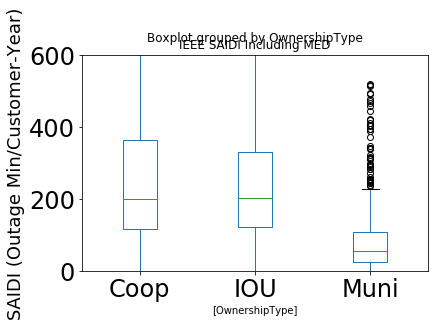

In [5]:
axes = plt.axes()
axes.set_ylim([0, 600])
axes.set_ylabel('SAIDI (Outage Min/Customer-Year)',fontsize=18)
#axes.set_xlabel('Ownership Type')
step2.boxplot(column=['IEEE SAIDI Including MED'], by=['OwnershipType'],
                                      ax=axes,grid=False,fontsize=24)

I showed this to a few friends in the field and their response was something like "yes, this is just because muni's are smaller (towns, cities) and serve more dense service areas with more underground lines, shorter lines between customers, etc." So let's look at the diagnostics on that in the data.

First we will look at just gross size, then deal with customer density.

In [6]:
print('Utility-years of the three main categories in the data: ')
print(step2['OwnershipType'].value_counts())
print(' ')
print('Average total customers service within the three categories: ')
print(step2.groupby(['OwnershipType']).mean()['IEEE Total Customers'])

Utility-years of the three main categories in the data: 
Coop    1724
IOU     1062
Muni     802
Name: OwnershipType, dtype: int64
 
Average total customers service within the three categories: 
OwnershipType
Coop     34448.379350
IOU     556246.711864
Muni     70319.799252
Name: IEEE Total Customers, dtype: float64


## Gross Size Check

So pretty different. The average IOU serves about 8x as many customers as the average muni. With this in mind let's see if the size of a utility generally matters to its reliability.

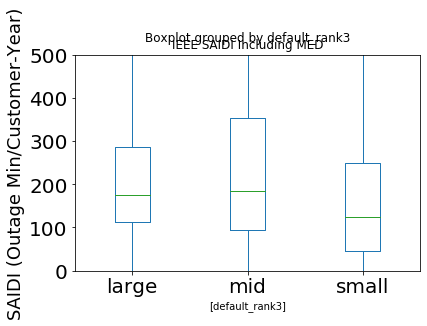

In [7]:
# check one last quick thing - does utility size seem to matter generally? Now that we know IOUs are much larger

#define our plotting function
def plot_size_groups(df,cuts_list,cuts_labels):
    size_frame = df.copy()
    size_frame['default_rank'] = list(size_frame['IEEE Total Customers'].rank())
    size_frame ['default_rank2'] = list(size_frame['IEEE Total Customers'].rank())

    #cut these ranks into my chosen cutoffs for "small","medium", and "large" utilities
    new_ranks = size_frame[['default_rank','default_rank2']].apply(lambda x : pd.cut(x,cuts_list,labels=cuts_labels))

    size_frame['default_rank3'] = list(new_ranks['default_rank'])

    axes2 = plt.axes()
    axes2.set_ylim([0, 500])
    axes2.set_ylabel('SAIDI (Outage Min/Customer-Year)',fontsize=18)
    size_frame.boxplot(column=['IEEE SAIDI Including MED'], by=['default_rank3'],ax=axes2,grid=False,fontsize=20)
    
#we need a way to create logical cutoffs on utility size, but let's just group in thirds for now
size_cuts = [-1,len(step2.index)*1/3,len(step2.index)*2/3,len(step2.index)]

plot_size_groups(step2,size_cuts,['small','mid','large'])

Gross utility size just doesn't look all that important so I'm not going to try fancy grouping. Let's focus instead on density (customers per square mile), since that's what people told me was important anyway. I'll need geographic data on the extent of a utility's service territory to do this, so let's go grab it.

## Load and join service territory data

VelocitySuite also provides data on a utility's service area (territory). This will tell me how large (square miles) each utility is, which I can map against what I already know about how many customers they serve to get their service territory density (customers/square mile). Then we can see if the differences are just from muni service territitories being denser (the hypothesis most people I talked to pointed to). 

As these folks intuited, we will see below that Muni's have much denser (and smaller) service areas, while Coops serve very rural (low density) areas and IOUs are somewhere in between (though tend to be largest in size because they have a lot of customers).

In [8]:
#load and clean service area data
service_area = pd.read_csv("service_area_VS.csv",encoding = "ISO-8859-1") #load

def slice_service_area(service_area):
    service_area_small = service_area[['Company Name','Area (sq mi)','Bundled Total Customers','Population 2010']].copy() #retain only columns of interest
    service_area_small['Customers per Sq Mi'] = service_area_small['Bundled Total Customers']/service_area_small['Area (sq mi)'] #calculate density
    service_area_small['Pop per Sq Mi'] = service_area_small['Population 2010']/service_area_small['Area (sq mi)'] #a different (population-based) definition of density
    return service_area_small
service_area_small = slice_service_area(service_area)

#merge with existing data
#these datasets have consistent company names, as they're both from VelocitySuite, so can merge on that
wservicearea = pd.merge(step2,service_area_small,how='left',left_on=['Company Name'],right_on=['Company Name'])
wservicearea.dropna(how='any', subset=['Area (sq mi)'], inplace=True) #if no reported service area, drop

#set a rank
#create quintiles or ranks
wserviceareaplot = wservicearea.copy() 
wserviceareaplot['IEEE Customers per Sq Mi'] = wserviceareaplot['IEEE Total Customers']/wservicearea['Area (sq mi)']#IEEE defined customer density
wserviceareaplot['Density_rank'] = wserviceareaplot['IEEE Customers per Sq Mi'].rank()
wserviceareaplot['Density_rank2'] = wserviceareaplot['IEEE Customers per Sq Mi'].rank()

service_area_group = wserviceareaplot.groupby(["OwnershipType"],as_index=False).mean()

print('reported average area and density by utility type:')
print(service_area_group[['OwnershipType','Area (sq mi)','IEEE Customers per Sq Mi']].head())

reported average area and density by utility type:
  OwnershipType  Area (sq mi)  IEEE Customers per Sq Mi
0          Coop   1974.189216                 33.350566
1           IOU  38601.280242                120.102982
2          Muni    303.138036               1974.343030


## Implement KMeans++ to cluster on density

Generally I think of three simple density categories as Urban, Mixed, and Rural. However, I'm not sure I have operational defintions for what these words mean, beyond the obvious that New York City is urban and most of Wyoming is rural. So let's try to operationalize these categories as clusters using K-Means++. 

To do this I create three customer density centroids. After some exploratory investigation, I realized this is best done on the log population density, as the skew of some extremely dense utilities otherwise leads to just a handful (<20) being clustered as urban. Utilities are then matched to the closest centroid by their density, with the lowest density centroid being defined as Rural, the middle as Mixed, and the top as Urban. 

In [9]:
wservicearea_np = np.asarray(wserviceareaplot['IEEE Customers per Sq Mi'])
#print(wservicearea_np.shape)
kmeans_fit = KMeans(n_clusters=3,init='k-means++').fit(np.log(wservicearea_np[:,None]))

unique_elements, counts_elements = np.unique(kmeans_fit.labels_, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))
mycounts = counts_elements
mycenters = (kmeans_fit.cluster_centers_)
print('and the cluster centers (in log utility customers per square mile)')
print(mycenters)

count_array = np.vstack((np.exp(mycenters).flatten(),mycounts,mycounts))
getcounts = count_array[count_array[0,:].argsort()]

cut1 = round(getcounts[1,0],2)
cut2 = round(getcounts[1,1]+cut1,2)
cut3 = round(getcounts[1,2]+cut2,2)
print('yielding cutoffs in rank-ordered utility density dataset at')
print(cut1,cut2,cut3)
print('this means the lowest density '+str(cut1)+ ' utility-years are Rural, the '+str(cut1)+'-'+str(cut2)+' densest are mixed, and the top ' + str(cut3-cut2) + ' are urban')

Frequency of unique values of the said array:
[[   0    1    2]
 [1734  885  925]]
and the cluster centers (in log utility customers per square mile)
[[3.4676277 ]
 [7.05630744]
 [1.0822276 ]]
yielding cutoffs in rank-ordered utility density dataset at
32.06 1192.21 1195.16
this means the lowest density 32.06 utility-years are Rural, the 32.06-1192.21 densest are mixed, and the top 2.9500000000000455 are urban


With this in place we can group and plot the density clusters by utility type

R is Rural, M is Mixed, U is Urban on the below plot

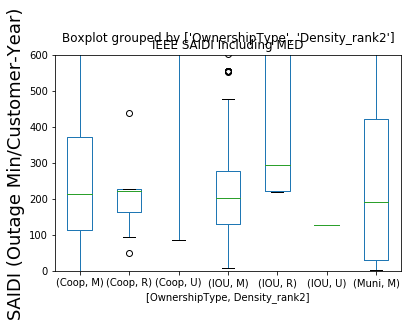

<Figure size 576x576 with 0 Axes>

In [10]:
def create_density_ranks(df,cuts,labels):
    try:
        new_ranks = df[['Density_rank','Density_rank2']].apply(lambda x : pd.cut(x,cuts,labels=labels))
        df['Density_rank2'] = list(new_ranks['Density_rank'])
    except TypeError:
        pass
    df.groupby(['OwnershipType'],as_index=False).mean()
    return df

density_cuts = [-1,cut1,cut2,cut3]
density_labels = ['R','M','U']
wserviceareaplot_density = create_density_ranks(wserviceareaplot,density_cuts,density_labels)

axes2 = plt.axes()
axes2.set_ylabel('SAIDI (Outage Min/Customer-Year)',fontsize=18)
axes2.set_ylim([0, 600])

p1 = plt.figure(figsize=(8,8))
p1 = wserviceareaplot_density.boxplot(column=['IEEE SAIDI Including MED'], by=['OwnershipType','Density_rank2'],
                     figsize=(8,8),ax=axes2,grid=False,fontsize=10)#
plt.show(p1)

It does appear to be the case denser (urban) utilities have better reliability (lower bars on plot), but it sure does still look like urban munis do better than their urban IOU counterparts. Let's try to operationalize this hypothesis.

## Mapping Data Load

You need geopandas/descartes for this so make sure you have it.

This is my final data check. Is there something big I'm missing? I figured an easy way to do that is to plot reliability (SAIDI) by utility-type on a map of the United States. Then I can see if any big geographic bias jumps out that I should try to include but forgot about.

To do this mapping I obtain a publicly available shapefile of electric utility service territories from [HIFLD](https://hifld-geoplatform.opendata.arcgis.com/datasets/c4fd0b01c2544a2f83440dab292f0980_0). Shapefiles for US state boundaries are widely available, so I also get one of those as it'll help with visualization to draw state boundaries.

In [11]:
map_df = gpd.read_file(os.path.join(os.getcwd(),'Electric_Retail_Service_Territories.shp'))
usa = gpd.read_file(os.path.join(os.getcwd(),'states.shp'))
map_df.head() #give a sense of what the geopandas df looks like

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,TELEPHONE,TYPE,COUNTRY,...,NET_EX,RETAIL_MWH,WSALE_MWH,TOTAL_MWH,TRANS_MWH,CUSTOMERS,YEAR,SHAPE__Are,SHAPE__Len,geometry
0,1001,14203,CITY OF OSAWATOMIE - (KS),700 WALNUT AVENUE,OSAWATOMIE,KS,66064,NOT AVAILABLE,MUNICIPAL,USA,...,0,27389,-999999,34004,0,2082,2017,9.810024e+06,25721.098302,"MULTIPOLYGON (((-94.94242 38.51387, -94.94264 ..."
1,1002,10559,CITY OF LA CROSSE - (KS),P O BOX 339,LACROSSE,KS,67548,NOT AVAILABLE,MUNICIPAL,USA,...,-999999,10923,-999999,-999999,-999999,890,2017,9.537604e+06,12653.080165,"POLYGON ((-99.29905 38.54267, -99.29924 38.515..."
2,1003,3710,CITY OF CLAY CENTER - (KS),427 COURT ST,CLAY CENTER,KS,67432,NOT AVAILABLE,MUNICIPAL,USA,...,0,44148,-999999,50021,0,2764,2017,9.399764e+06,24613.198394,"MULTIPOLYGON (((-97.12801 39.37206, -97.12810 ..."
3,1004,16440,CITY OF RUSSELL - (KS),P O BOX 112,RUSSELL,KS,67665,NOT AVAILABLE,MUNICIPAL,USA,...,0,106623,163,120160,0,3385,2017,8.838890e+06,23456.007757,"POLYGON ((-98.87305 38.89113, -98.87305 38.891..."
4,1005,1148,CITY OF BALDWIN CITY- (KS),P O BOX 86,BALDWIN CITY,KS,66006,NOT AVAILABLE,MUNICIPAL,USA,...,0,30691,-999999,33940,0,1982,2017,8.778268e+06,19818.116859,"POLYGON ((-95.19218 38.78222, -95.19218 38.782..."


## Clean and join HIFLD data with reliability data to enable plotting

What I see here is the shapefile retains EIA utility numbers in its "ID" column. This is why I ended up going back at the start and joining the EIA utility numbers to my original dataset. This now pays off as I can join on that column. 

In [12]:
#remap utility type in geopandas shapefile data, which are slightly different than they were in the other file
data_dict2 = {"INVESTOR OWNED":"IOU",'COOPERATIVE':'Coop','MUNICIPAL':'Muni','POLITICAL SUBDIVISION':'Muni','FEDERAL':'Muni',
            'WHOLESALE POWER MARKETER':'IOU','STATE':'Muni','MUNICIPAL MKTG AUTHORITY':'Muni','NOT AVAILABLE':'Coop'}
map_df['Type_simple'] = [data_dict2[i] for i in map_df['TYPE']]

#attempt joins against other data as a check
data_2018 = wserviceareaplot_density[wserviceareaplot_density['Year']==2018]
asmerged = pd.merge(map_df,data_2018,how='left',left_on=['NAME'],right_on=['Company Name'])
asmerged['OwnershipType'].fillna('None',inplace=True)

#check what remains
nadropped = asmerged.dropna(how='any', subset=['IEEE SAIDI Including MED'])
nadroppedfilter = nadropped[nadropped['IEEE SAIDI Including MED']<1000].copy() #these mess with the plot scale so just drop them, there are very few

#drop id's with na from mapdf
map_df_nadrop = map_df[~map_df.ID.str.contains("NA")].copy()
map_df_nadrop['ID'] = map_df_nadrop['ID'].astype('float').copy()

Now I can do the joins.

In [13]:
#merged and drop rows that don't record reliability data for the utility-year
util_num_merged = pd.merge(map_df_nadrop,wserviceareaplot_density,how='left',left_on=['ID'],right_on=['Utility Number'])
util_num_merged_wdata_drop = util_num_merged.dropna(how='any',subset=['IEEE SAIDI Including MED','IEEE SAIDI Excluding MED'])

#another check on making sure we dropped results that don't have reliability recorded
util_num_merged_wdata = util_num_merged_wdata_drop[util_num_merged_wdata_drop['IEEE SAIDI Including MED']!='.'].copy()
util_num_merged_wdata = util_num_merged_wdata_drop[util_num_merged_wdata_drop['IEEE SAIDI Excluding MED']!='.'].copy()

#now that we've dropped the pesky string values for missing data, convert reliability data to float
util_num_merged_wdata['IEEE SAIDI Including MED'].astype('float',inplace=True) 
util_num_merged_wdata['IEEE SAIDI Excluding MED'].astype('float',inplace=True) 

#take log reliability, it's better for plotting
util_num_merged_wdata['logSAIDI With MED'] = np.log(util_num_merged_wdata['IEEE SAIDI Including MED']) 
util_num_merged_wdata['logSAIDI Without MED'] = np.log(util_num_merged_wdata['IEEE SAIDI Excluding MED'])

#and make sure we have the log customer density for plotting.
filter_util_num_merged_wdata = util_num_merged_wdata[util_num_merged_wdata['IEEE SAIDI Including MED']<1000].copy()
filter_util_num_merged_wdata['CustomerDensity'] = filter_util_num_merged_wdata['Customers per Sq Mi']
filter_util_num_merged_wdata['logCustomerDensity'] = np.log(filter_util_num_merged_wdata['CustomerDensity'])

C:\Users\llavi\Anaconda4\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
C:\Users\llavi\Anaconda4\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\llavi\Anaconda4\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Plot and interpret maps of US

This takes a few seconds to run. I wanted to panel the figures but couldn't quite figure it out. Regardless, I don't see much pattern here across the years, besides that a few IOUs have some quite high SAIDI in a few years (mostly in Maine, West Virginia, and quite a few in the Southeastern US in 2016, so I guess there must have been a big hurricane or something (Wikipedia [appears to confirm 2016](https://en.wikipedia.org/wiki/2016_Atlantic_hurricane_season) as a highly active hurricane season, but I'm not going to investigate this further).

I'm having trouble with the legend, so I'll describe it below
- Red: IOU service territories
- Green: Muni service territories
- Blue: Coop service territories

Intensity of color is a function of SAIDI in that year. I've included that scaled legend (it's in red, but applies to all utilities regardless of color). Entirely white areas (Nebraska) are missing data. I can't figure out how to control the size. so I include the scaled legend only once (in 2018).

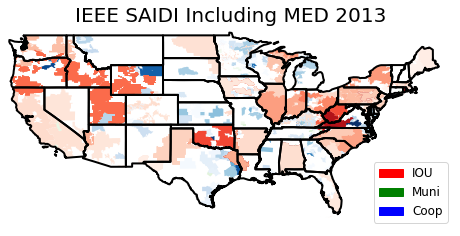

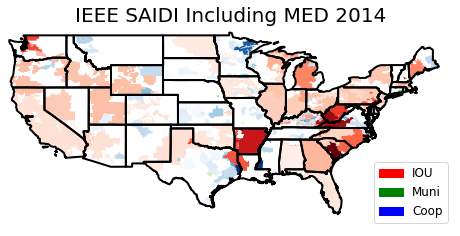

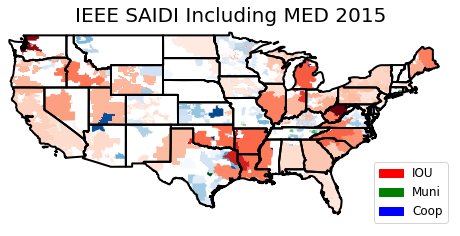

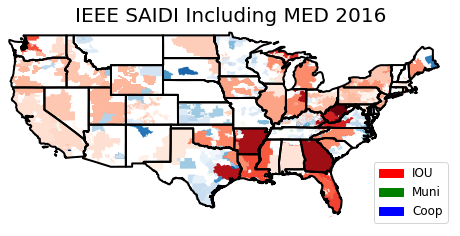

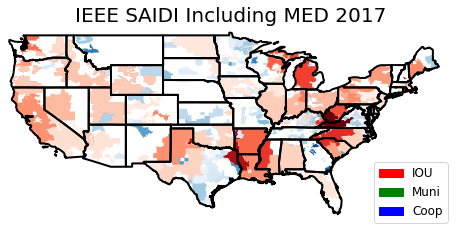

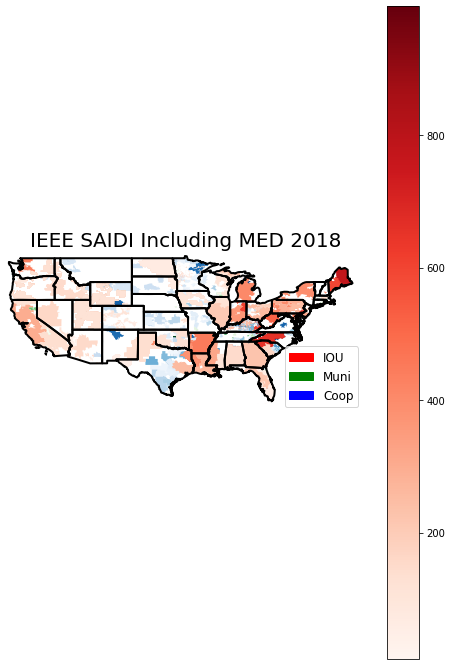

In [14]:
def plotyear(year,filter_util_num_merged_wdata,colname):
    filter_util_num_merged_wdata = filter_util_num_merged_wdata[filter_util_num_merged_wdata['Year']==year]
    fig, ax = plt.subplots(1, figsize=(8, 12))
    #set axes
    myaxes = plt.axes()
    myaxes.set_ylim([23, 50])
    myaxes.set_xlim([-125,-65])
    myaxes.set_title(colname+' '+str(year), fontdict={'fontsize': '20', 'fontweight' : '3'})
    IOUlabel = mpatches.Patch(color='red', label='IOU')
    munilabel = mpatches.Patch(color='green',label='Muni')
    coop = mpatches.Patch(color='blue',label='Coop')
    myaxes.legend(handles=[IOUlabel,munilabel,coop],fontsize=12,loc='lower right')
    myaxes.axis('off')

    #myplot = plt.figure(figsize=(15,20))
    myplot = filter_util_num_merged_wdata[filter_util_num_merged_wdata['TYPE']=='MUNICIPAL'].plot(ax=myaxes,column=colname,cmap='Greens')
    myplot = filter_util_num_merged_wdata[filter_util_num_merged_wdata['TYPE']=='COOPERATIVE'].plot(ax=myaxes,column=colname,cmap='Blues')
    if year==2018:
        myplot = filter_util_num_merged_wdata[filter_util_num_merged_wdata['TYPE']=='INVESTOR OWNED'].plot(ax=myaxes,column=colname,legend=True,cmap='Reds')
    else:
        myplot = filter_util_num_merged_wdata[filter_util_num_merged_wdata['TYPE']=='INVESTOR OWNED'].plot(ax=myaxes,column=colname,cmap='Reds')
        
    myplot = usa.plot(ax=myaxes,edgecolor='k',linewidth=2,facecolor='None') #add back state borders
    return myplot

years=[2013,2014,2015,2016,2017,2018]
for y in years:
    plotyear(y,filter_util_num_merged_wdata,'IEEE SAIDI Including MED')

## Hypothesis Testing with Linear Regression

So seeing nothing else, we have our hypothesis: IOUs being less reliabile than particularly munis is just an artifact of muni's denser service territories. We don't see a time trend in the above data, so seems ok to take all utility-years together in a single regression. Let's test our hypothesis.

To do this we will run four linear regressions. The first is "AllFit" and is run on all utility-years of data. There are then three "pooled" regressions, one for each utility type (IOU, Muni, Coop; red/green/blue color scheme as above). 

Obtaining best fit regressions for all and then pooled data, we can then test the slope of the lines for statistically significant differences, which would indicate that increasing density does not completely explain the higher reliabilty of munis.

C:\Users\llavi\Anaconda4\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\llavi\Anaconda4\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


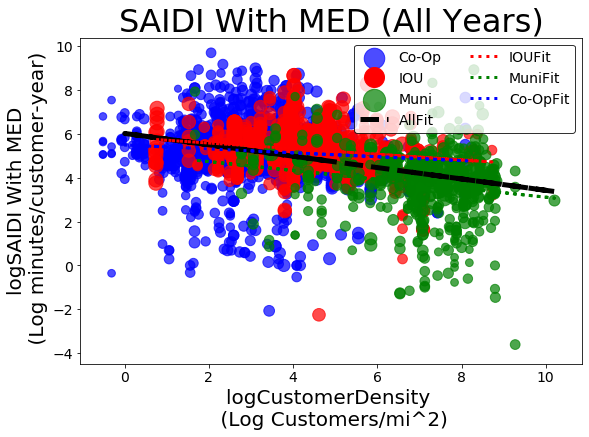

In [15]:
#util_num_merged_wdata['CustomerDensity'] = util_num_merged_wdata['CUSTOMERS']/(util_num_merged_wdata['SHAPE__Are']/5000000)
util_num_merged_wdata['CustomerDensity'] = util_num_merged_wdata['Customers per Sq Mi']
util_num_merged_wdata['logCustomerDensity'] = np.log(util_num_merged_wdata['CustomerDensity'])
#print(util_num_merged_wdata.columns)

ycol = 'logSAIDI With MED' 

plt.figure(figsize=(9,6))

s1 = plt.scatter(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='COOPERATIVE']['logCustomerDensity'],
            util_num_merged_wdata[util_num_merged_wdata['TYPE']=='COOPERATIVE'][ycol],
            s = np.log(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='COOPERATIVE']['CUSTOMERS'])**2,
            color = 'b', alpha=0.7, label='Co-Op')
s2 = plt.scatter(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='INVESTOR OWNED']['logCustomerDensity'],
            util_num_merged_wdata[util_num_merged_wdata['TYPE']=='INVESTOR OWNED'][ycol],
            s = np.log(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='INVESTOR OWNED']['CUSTOMERS'])**2,
            color = 'r', alpha=0.7, label='IOU')
s3 = plt.scatter(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='MUNICIPAL']['logCustomerDensity'],
            util_num_merged_wdata[util_num_merged_wdata['TYPE']=='MUNICIPAL'][ycol],
            s = np.log(util_num_merged_wdata[util_num_merged_wdata['TYPE']=='MUNICIPAL']['CUSTOMERS'])**2,
            color = 'g', alpha=0.7, label='Muni')
plt.xlabel('logCustomerDensity \n (Log Customers/mi^2)',fontdict={'fontsize': '20'})
plt.ylabel(ycol+'\n (Log minutes/customer-year)',fontdict={'fontsize': '20'})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#pool and fit lines
regr = linear_model.LinearRegression()

#remove nan and negative logvalues
util_num_merged_wdata_logdrop = util_num_merged_wdata.replace([np.inf, -np.inf], np.nan).dropna(how='any', subset=['logSAIDI With MED','logCustomerDensity'])
util_num_merged_wdata_logdrop = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['logCustomerDensity']>0] 


y = util_num_merged_wdata_logdrop[ycol].values[:,None]
x = util_num_merged_wdata_logdrop['logCustomerDensity'].values[:,None]

regr.fit(x, y)
r1, = plt.plot(x, regr.predict(x), color='k', linewidth=5, linestyle='--', label='AllFit')
allfitpreds = regr.predict(x)

y = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='INVESTOR OWNED'][ycol].values[:,None]
x = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='INVESTOR OWNED']['logCustomerDensity'].values[:,None]
regr.fit(x, y)
r2, = plt.plot(x, regr.predict(x), color='r', linewidth=3,linestyle='dotted',label='IOUFit')

y = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='MUNICIPAL'][ycol].values[:,None]
x = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='MUNICIPAL']['logCustomerDensity'].values[:,None]
regr.fit(x, y)
r3, = plt.plot(x, regr.predict(x), color='g', linewidth=3,linestyle='dotted',label='MuniFit')

y = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='COOPERATIVE'][ycol].values[:,None]
x = util_num_merged_wdata_logdrop[util_num_merged_wdata_logdrop['TYPE']=='COOPERATIVE']['logCustomerDensity'].values[:,None]
regr.fit(x, y)
r4, = plt.plot(x, regr.predict(x), color='b', linewidth=3, linestyle='dotted',label='Co-OpFit')


red_circle = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                          markersize=10, label='IOU')

my_legend = plt.legend(handles=[s1,red_circle,s3,r1,r2,r3,r4], loc='upper right',ncol=2
                       ,fontsize=14,markerscale=2,framealpha=0.8,edgecolor='k')

plt.title('SAIDI With MED (All Years)',fontdict={'fontsize': '32', 'fontweight' : '3'})

plt.show()

## Tests for statistical significance in regression

I wasn't quite sure how to show a standard regression table in Python (am used to R for this), but found some help [here](https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression)

In [16]:
# I wasn't sure how to get regression tables in Python, but found an explainer here: https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
#set up regression
X = util_num_merged_wdata_logdrop['logCustomerDensity'].values[:,None]
y = util_num_merged_wdata_logdrop[ycol].values[:,None]
bools = np.asarray(pd.get_dummies(util_num_merged_wdata_logdrop['TYPE'])[['COOPERATIVE','INVESTOR OWNED','MUNICIPAL']])

X2 = np.hstack((X,bools)) #this time I don't have to plot so just add booleans to the regression for utility types

X3 = sm.add_constant(X2) #add intercept term, it'll make things a bit more interpretable

est = sm.OLS(y, X3)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     224.1
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          6.68e-171
Time:                        20:02:56   Log-Likelihood:                -5470.0
No. Observations:                3392   AIC:                         1.095e+04
Df Residuals:                    3387   BIC:                         1.098e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7823      0.148     32.274      0.0

Alright so we see a couple things

- coefficient x4 (isMuni) is not statistically significantly different from 0, while x2 and x3 (isCoop and isIOU, respectively) are and are positive. In fact, the best estimate is that isIOU is 1.06, meaning being an IOU vs. muni is associated with about a log order of magnitude (2.7x) increase in SAIDI.
- x1 is statistically significant and less than zero, so, as hypothesized, increasing density does decrease SAIDI
- R2 is .209, so the regression is finding something, but I wouldn't call it an amazing prediction of SAIDI outcomes.

Honestly, I have to kind of preliminarily conclude Bernie and other IOU detractors have a point. It would appear that if PG&E were split up into a bunch of municipal utilities, its reliability would improve. There are a **TON** of things we haven't (and some we can't) explore here, but it's interesting and not what I expected. Some examples are the real-world difficulty of agreeing on a price to purchase IOU assets and transition ([here is the history of Boulder, CO's drawn-out process](http://empowerourfuture.org/boulder-municipalization-a-history/)) and the fact we can't really try to correct for possible selection bias in municipalization (i.e., do the areas that have municipalized just have "better" governance structures that couldn't be replicated elsewhere?). 

We can also quickly check for satisfaction of some of the standard linear regression assumptions. This will be a little more hairy and you're free to skip it.

## Evaluation of residuals

Text(0.5, 0, 'Fitted Values')

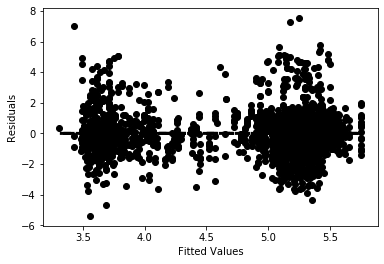

In [17]:
#report some residuals from the above plots, just as a check
regr.fit(X3, y) #refit standard sklearn model on all features

predictions = regr.predict(X3)
y = util_num_merged_wdata_logdrop[ycol].values[:,None]
plt.scatter(predictions,predictions-y,c='k')

regr.fit(predictions, predictions-y)
plt.plot(predictions, regr.predict(predictions), color='k', linewidth=3, linestyle='--', label='ResidFit')

plt.ylabel('Residuals')
plt.xlabel('Fitted Values')

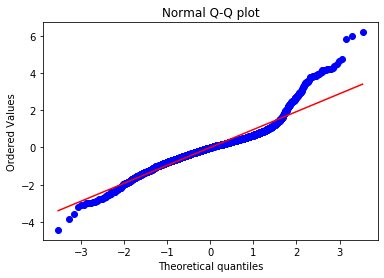

In [18]:
resids = predictions-y
resids = resids.reshape((resids.shape[0],))
z = (resids-np.mean(resids))/np.std(resids)
stats.probplot(z, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

I'm out of time to really try to correct for the issues here, but there are some. We see a ton of heteroskedasticity in the residuals v. fitted values plot (see how much the variance in residuals decreases then increases along the x-axis?). We also have some skew in the quantile-quantile plot associated with logSAIDI values where the model is really whiffing. Honestly, my best guess is the utilities associated with those values have incorrectly or misreported data, and should be dropped from the regression so that their outlier points stop exerting so much leverage on the resulting best-fit line. Then I'd re-run the regression. But I just don't have time to try to diagnose these points and whether they're likely reporting errors.

## Skip to Baseball Model

If you've done this without running the electricity module, **please** ensure you go back and load the Python libraries in the first code block. You'll need them.

## Baseball Topics
- [Skip to Baseball Model](#Skip-to-Baseball-Model)
- [Baseball Stats 101](#Baseball-Stats-101)
- [Baseball Data Load](#Baseball-Data-Load)
- [Create features](#Create-features)
- [Davenport data join](#Davenport-data-join)
- [MLB WAR outcomes](#MLB-WAR-outcomes)
- [Join MLB and minor league data](#Join-MLB-and-minor-league-data)
- [Run Logistic Regression](#Run-Logistic-Regression)
- [Visualizing Logistic Regression Results](#Visualizing-Logistic-Regression-Results)
- [Logistic Regression forecasts of current minor leaguers](#Logistic-Regression-forecasts-of-current-minor-leaguers)
- [Neural Network Approach Intro](#Neural-Network-Approach-Intro)
- [Run Neural Network](#Run-Neural-Network)
- [Run Neural Net on Future Years](#Run-Neural-Net-on-Future-Years)
- [Overwrite Neural Net Results with Previously trained model](#Overwrite-Neural-Net-Results-with-Previously-trained-model)
- [Payoff: Final Results](#Payoff:-Final-Results)

I'm going to be much more terse in explanations here as this is an addenda to the main report. The logic chain of the approach's utility may be hard to follow if you don't have a good grasp of the rules of baseball and hierarchy of minor league (development) teams that sit under the 30 Major League Baseball teams, though I'll give a short explainer below (which you can skip too).

## Baseball Stats 101

I guess, if you're not a baseball person (totally fine), the big thing to understand is baseball can be modeled as a series of discrete plays, generally involving someone who throws and someone who hits the ball. Different outcomes have different values. Baseball statistical analysts ("SABRmetricians", after the [Society for American Baseball Research, SABR](https://sabr.org/) have assigned values to these plays in terms of the points (runs) each creates in expectation; these values can then be aggregated into a player's ["Wins Above Replacement" (WAR)](https://library.fangraphs.com/misc/war/), which is an estimate of the number of additional games the player's team won by having that player instead of a "replacement" player (generally you can think of this as the player that player would be replaced by if the player were injured; i.e., more-or-less the best player not currently on the team's roster). 

This project uses minor league stats to predict how much WAR (value, basically) a player will produce in his early career. The reason for limiting to early career is players are only bound to the team that drafts them for a set number of years (MLB, another monopoly!), after which they can become free agents and sign with whichever team they want ([usually the highest bidder](https://www.mlb.com/breaking-news/yankees-gerrit-cole-offer)). An age cutoff is used as a proxy for this until I get better service time data. Hopefully it's evident why it's useful to a team (or a fantasy baseball player) to have an idea of how a teenager will perform over the next decade.

### Statistical Disclaimer

From a stastical standpoint, an important thing to note is this approach will **ASSUME** forward exogeneity in predicting player outcomes. That is, it assumes player stats from 1998-2015 (approximate range of historic minor league seasons with known player outcomes in MLB) and player stats from 2017-2019 (where MLB outcome isn't yet known) come from the same underlying distributions. There may be some issues with this, but generally the rules of baseball have not changed. In the future I'd prefer to withhold the test set for the historical data from later years (say, predict 2012-2015 outcomes from 1998-2011 data only) to get a better sense of this, but for now cross-validation of the model(s) is randomly sampled from the 1998-2015 player-seasons. Also, 1998 is a bit of an arbitrary beginning point, I chose it because its when new teams most recently entered the league. I was worried my web scrapers would break if I went back before these teams existed.

## Baseball Data Load

I use a few different data sources. In many cases I had to write a separate HTML scraper, but they generally take over an hour to run so I'm just zipping the resulting csvs here. HTML scrapers are available in my [Github repo](https://github.com/llavin13/).

1. MLB historical WAR: from Fangraphs. CSVs can be created [here](https://www.fangraphs.com/leaders.aspx?pos=all&stats=bat&lg=all&qual=y&type=8&season=2019&month=0&season1=2019&ind=0) if you know the UI.
2. Steamer WAR: from Fangraphs. Can be created [here](https://www.fangraphs.com/projections.aspx?pos=all&stats=bat&type=steamer). I use this to project future performance for players with a good amount of play, but who aren't quite yet 28 years old (since we have a pretty good idea of how they've turned out and more recent stats are preferable).
3. Minor League Baseball data: from Baseball Reference. Here I had to write a scraper. [URL for an example of a scraped team page](https://www.baseball-reference.com/register/affiliate.cgi?id=ARI&year=2019) (scraper goes through all 30 teams over 20+ years). 
4. Clay Davenport Minor League Baseball data: another repository of minor league data that records some different stats I want to use than does Baseball Reference. Again, I needed a scraper (same reason). [Here is an example URL](http://claydavenport.com/stats/webpages/2000/2000pageINTrealALL.shtml).

Data and models will generally be split between hitters (or position players) and pitchers, essentially the two discrete job types in baseball (one hits the ball, the other throws it to him) since they accrue stats in different ways.

In [19]:
##data loads##

#1. mlb historical war data from fangraphs
mlb_data = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\FanGraphs Leaderboard MLB_1985_2019.csv'))
mlb_data_pitching = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\FanGraphs Leaderboard Pitching_1985_2019.csv'))

#2. fangraphs steamer 2020 projections for projecting out younger player production thru age 28
steamer2020 = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\steamer_2020.csv'))
steamer2020_pitching = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\steamer_2020_pitching.csv'))

#3. baseball reference milb data pull
milb_bref = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\minorsbatting.csv'),encoding = "ISO-8859-1")
milb_bref_pitching = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\minorspitching.csv'),encoding = "ISO-8859-1")

#4. davenport data (fielding, mostly)
davenport_hitting = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\davenporthitting.csv'))
davenport_pitching = pd.read_csv(os.path.join(os.getcwd(),'baseball_data\\davenportpitching.csv'))

C:\Users\llavi\Anaconda4\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
milb_bref = milb_bref[milb_bref['Age']!='--']#'Agein2019']['Agein2019']
milb_bref['Agein2019'] = milb_bref['Age'].astype(float)+(2019-milb_bref['season'].astype(float))

milb_bref_pitching = milb_bref_pitching[milb_bref_pitching['Age']!='--']#'Agein2019']['Agein2019']
milb_bref_pitching['Agein2019'] = milb_bref_pitching['Age'].astype(float)+(2019-milb_bref_pitching['season'].astype(float))


#add a cleaned name column; we'll need this for improve matching later
#first for position players
milb_bref['Name'] = milb_bref['Name'].str.replace(r'[^A-Za-z\s]+', '')
new_index= list(range(len(milb_bref.index)))
milb_bref = milb_bref.reindex(new_index)

#then pitchers
milb_bref_pitching['Name'] = milb_bref_pitching['Name'].str.replace(r'[^A-Za-z\s]+', '')
new_index= list(range(len(milb_bref_pitching.index)))
milb_bref_pitching = milb_bref_pitching.reindex(new_index)

#print([z.replace(, '') for z in milb_bref['Name']])
brefids_tomatch = milb_bref[['Name','min_playerid','Agein2019']].drop_duplicates(subset='min_playerid', keep="first").reset_index()
brefpitchingids_to_match = milb_bref_pitching[['Name','min_playerid','Agein2019']].drop_duplicates(subset='min_playerid', keep="first").reset_index()

## Create features

There are some additional features I'll want in my model that are combinations of the ones already in the loaded datasets. I create them below. Terse, so not going to explain why I want each one, just know I think they're stats that are predictive of player performance.

This cell takes ~80 seconds to run on my machine.

In [21]:
#create additional milb bref features
#print(milb_bref.columns)
milb_bref['ISO'] = milb_bref['SLG']-milb_bref['BA']
milb_bref['AVG'] = milb_bref['BA']
milb_bref['SO%'] = milb_bref['SO']/milb_bref['PA']
milb_bref['BB%'] = (milb_bref['BB']+milb_bref['IBB'])/milb_bref['PA']
milb_bref['SB%'] = milb_bref['SB']/(milb_bref['SB']+milb_bref['CS'])
milb_bref['SBperPA'] = milb_bref['SB']/milb_bref['PA']
milb_bref['PAperG']= milb_bref['PA']/milb_bref['G']
milb_bref['GDPperAB'] = milb_bref['GDP']/milb_bref['AB']
milb_bref['HRperAB'] = milb_bref['HR']/milb_bref['AB']
milb_bref['HBPperPA'] = milb_bref['HBP']/milb_bref['PA']
milb_bref['SO_BB'] = milb_bref['SO%']/milb_bref['BB%']

#create additional pitching features
#print(milb_bref_pitching.columns)
milb_bref_pitching['IP_G'] = milb_bref_pitching['IP']/milb_bref_pitching['G']
milb_bref_pitching['%GS'] = milb_bref_pitching['GS']/milb_bref_pitching['G']

#drop doubles and triples columns so they don't interfere with positions that have the same label
if '2B' in milb_bref.columns:
    milb_bref = milb_bref.drop('2B', 1)
    milb_bref = milb_bref.drop('3B', 1)

#create level columns if they aren't already in there from previously running this cell
if 'A-' not in milb_bref.columns:
    bref_levels = ['FRk','Rk','A-','A','A+','AA','AAA']
    level_dict = {}
    for l in bref_levels:
        print('adding level: '+str(l))
        level_dict[l] = [0.]*len(milb_bref.index)
        for v in range(len(milb_bref['Lev'])):
            if type(milb_bref.loc[v,'Lev'])==float:
                continue
            else:
                for level in milb_bref.loc[v,'Lev'].split(','):
                    if level==l:
                        level_dict[l][v]+=1.
                        
    milb_bref = pd.merge(milb_bref, pd.DataFrame.from_dict(level_dict), left_index=True, right_index=True)


#get position playtime
if '1B' not in milb_bref.columns:
    bref_positions = ['P','C','1B','2B','SS','3B','LF','CF','RF','DH']
    position_dict = {}
    for l in bref_positions:
        print('adding position: '+str(l))
        position_dict[l] = [0.]*len(milb_bref.index)
        #position_dict[l] = []
        for v in range(len(milb_bref['Lev'])):
            if type(milb_bref.loc[v,milb_bref.columns[27]])==float:
                continue
            else:
                if l=='C':
                    searchstring = milb_bref.loc[v,milb_bref.columns[27]].replace('CF','')
                else:
                    searchstring = milb_bref.loc[v,milb_bref.columns[27]]
                if l in searchstring:
                    position_dict[l][v]+=float(re.findall(r'\d+', searchstring[searchstring.find(l)+1:])[0])

    milb_bref = pd.merge(milb_bref, pd.DataFrame.from_dict(position_dict), left_index=True, right_index=True)
    for position in bref_positions:
        milb_bref[position] = milb_bref[position]/milb_bref['G']
        
#create level columns if they aren't already in there from previously running this cell, this time for pitchers
if 'A-' not in milb_bref_pitching.columns:
    bref_levels = ['FRk','Rk','A-','A','A+','AA','AAA']
    level_dict = {}
    for l in bref_levels:
        print('adding level: '+str(l)+' for pitchers')
        level_dict[l] = [0.]*len(milb_bref_pitching.index)
        for v in range(len(milb_bref_pitching['Lev'])):
            if type(milb_bref_pitching.loc[v,'Lev'])==float:
                continue
            else:
                for level in milb_bref_pitching.loc[v,'Lev'].split(','):
                    if level==l:
                        level_dict[l][v]+=1.
                        
    milb_bref_pitching = pd.merge(milb_bref_pitching, pd.DataFrame.from_dict(level_dict), left_index=True, right_index=True)
#print(milb_bref_pitching.iloc[:20,:])

adding level: FRk
adding level: Rk
adding level: A-
adding level: A
adding level: A+
adding level: AA
adding level: AAA
adding position: P
adding position: C
adding position: 1B
adding position: 2B
adding position: SS
adding position: 3B
adding position: LF
adding position: CF
adding position: RF
adding position: DH
adding level: FRk for pitchers
adding level: Rk for pitchers
adding level: A- for pitchers
adding level: A for pitchers
adding level: A+ for pitchers
adding level: AA for pitchers
adding level: AAA for pitchers


## Davenport data join
Remember how I got two datasets for minor league baseball data? Let's join the Davenport data to the Baseball Reference data.

In [22]:
#here is probably the time to join the Davenport data
davenport_subsetcols = ['Name','Age','Year','DRS1','DRS2','A','A+','A-','AA','AAA','Rk_y']
milb_bref['Age'] = milb_bref['Age'].fillna(30).astype(int)

milb_bref_wdavenport = milb_bref.merge(davenport_hitting[davenport_subsetcols],how='left',left_on=['Name','Age','season'],right_on=['Name','Age','Year'])

#reinsert level-based playtime
dav_levels = ['Rk_y','A-','A','A+','AA','AAA']
dav_levels_rename = ['A_y','A+_y', 'A-_y', 'AA_y', 'AAA_y', 'Rk_y_y']
for l in dav_levels_rename:
    milb_bref_wdavenport[l] = milb_bref_wdavenport[l].fillna(1.)

for l in dav_levels:
    milb_bref_wdavenport[l] = milb_bref_wdavenport[(l+'_y')]*milb_bref_wdavenport[(l+'_x')]
#print(milb_bref_wdavenport.columns)
#sum DRS
milb_bref_wdavenport['DRS1'] = milb_bref_wdavenport['DRS1'].fillna(0)
milb_bref_wdavenport['DRS2'] = milb_bref_wdavenport['DRS2'].fillna(0)
milb_bref_wdavenport['DRS'] = milb_bref_wdavenport['DRS2'] + milb_bref_wdavenport['DRS1']

#if collected, would also want to join batted ball data

## MLB WAR outcomes

Ultimately we are trying to predict a player's WAR, so let's get the data that's been observed for players in a usable format. This data will form the basis of the labels for training our model on historical data. I also print part of one of the outcome dataframes, if you know baseball you'll recognize some historical greats of the last 30 years.

In [23]:
#filter and group mlb data
def MLB_WAR_df(steamer2020,mlb_data,brefids_tomatch,agemax,service_max):
    steamer2020matcher = steamer2020[['WAR','playerid']]
    steamer2020matcher.columns = ['WARSteamer', 'playerid']
    #agemax = 28
    mlb_data['Agein2019'] = mlb_data['Age']+(2019-mlb_data['Season'])
    #
    
    #create service year
    mlb_data = mlb_data.sort_values(['playerid','Season']).reset_index()
    service_time_list = [1.]
    for i in range(1,len(mlb_data.index)):
        if mlb_data.loc[i,'playerid']==mlb_data.loc[i-1,'playerid']:
            service_time_list.append(service_time_list[-1]+1)
        else:
            service_time_list.append(1.)
    mlb_data['Service_Time'] = service_time_list 

    WARcalcs = mlb_data[mlb_data['Age']<=agemax].groupby(['playerid'],as_index=False).sum().sort_values('WAR',ascending=False)
    age2019avg = mlb_data[mlb_data['Age']<=agemax].groupby(['playerid'],as_index=False).mean().sort_values('WAR',ascending=False)
    
    #WARcalcs = mlb_data[mlb_data['Service_Time']<=service_max].groupby(['playerid'],as_index=False).sum().sort_values('WAR',ascending=False)
    #age2019avg = mlb_data[mlb_data['Service_Time']<=service_max].groupby(['playerid'],as_index=False).mean().sort_values('WAR',ascending=False)
    
    WARcalcs['Agein2019'] = age2019avg['Agein2019']
    
    service_in_2019 = mlb_data.groupby(['playerid']).size().reset_index(name='Servicein2019')
    #WARcalcs = WARcalcs.merge(service_in_2019,how='left',left_on=['playerid'],right_on=['playerid']).sort_values('WAR',ascending=False)
    

    #age2019avg = mlb_data[mlb_data['Age']<=agemax].groupby(['playerid'],as_index=False).mean().sort_values('WAR',ascending=False)
    
    WARcalcs = WARcalcs.merge(mlb_data[['Name','playerid']],how="left",left_on=['playerid'],right_on=["playerid"])
    WARcalcs = WARcalcs.drop_duplicates(subset='playerid', keep="first").reset_index()
    WARcalcs['playeridstr'] = WARcalcs['playerid'].astype('str')
    WARcalcs = WARcalcs.merge(steamer2020matcher,how='left',left_on=['playeridstr'],right_on=['playerid'])

    #WARcalcs['extraWARage'] = [service_max-min(service2019,service_max) for service2019 in WARcalcs['Servicein2019']]*WARcalcs['WARSteamer'].fillna(0)
    WARcalcs['extraWARage'] = [agemax-min(age2019,agemax) for age2019 in WARcalcs['Agein2019']]*WARcalcs['WARSteamer'].fillna(0)
    WARcalcs['finalWAR'] = WARcalcs['extraWARage']+WARcalcs['WAR']
    #finally, merge the bref ids to have a match with fg

    WARcalcs = WARcalcs.merge(brefids_tomatch,how="left",left_on=['Name','Agein2019'],right_on=['Name','Agein2019'])
    WARcalcs = WARcalcs.drop_duplicates(subset='playeridstr', keep="first").reset_index()
    return WARcalcs


WARcalcs = MLB_WAR_df(steamer2020,mlb_data,brefids_tomatch,28,7)
#WARcalcs.to_csv('check.csv')
WARcalcs.loc[43,'min_playerid'] = 'reyes-005jos' #two Jose Reyes born in 1983
#as a check print the top 5 players 1985-2019 by accrued WAR through agemax (28 here)
#print(WARcalcs.sort_values('finalWAR',ascending=False).iloc[:5,:])

WARcalcs_pitching = MLB_WAR_df(steamer2020_pitching,mlb_data_pitching,brefpitchingids_to_match,28,7)
WARcalcs_pitching.sort_values('finalWAR',ascending=False).iloc[:5,:]

,index,level_0,playerid_x,index_x,Season,W,L,SV,G,GS,...,Agein2019,Service_Time,Name,playeridstr,WARSteamer,playerid_y,extraWARage,finalWAR,index_y,min_playerid
0,0,0,2036,24037,18108,126,60,0,265,263,...,31.0,45.0,Clayton Kershaw,2036,4.4,2036,0.0,53.4,38635.0,kersha001cla
1,1,12,4772,45654,20095,125,92,0,303,303,...,33.0,55.0,Felix Hernandez,4772,0.8,4772,0.0,49.9,70709.0,hernan003fel
2,2,27,815,21460,13916,125,57,0,220,220,...,56.0,28.0,Roger Clemens,815,NaN,NaN,0.0,48.8,29881.0,clemen001wil
3,3,50,200,28573,17964,125,56,3,278,211,...,47.0,45.0,Pedro Martinez,200,NaN,NaN,0.0,48.8,50241.0,martin004ped
4,4,68,1004852,41743,17901,137,72,1,267,265,...,54.0,45.0,Dwight Gooden,1004852,NaN,NaN,0.0,44.0,20508.0,gooden001dwi


## Join MLB and minor league data

So that we have labels to predict on historical players. For the Logistic Regression model I'll use, this code also creates labels of player-outcome types as described below (with my rationale for choosing), ordered from worst to best. The next block of code then shows you the average WAR produced by a player in that category (which I'll need for converting Logistic Regression bin probabilities into WAR outcomes). In baseball stats parlance players are often bucketed by their value on a 20-80 value scale meant to be a normal distribution of MLB players with mean 50 and standard deviation 10, so I'll also highlight those "Future Value" (FV) tiers of the buckets.

- **NO MLB**: Player never played in MLB (FV<=30)
- **<2 WAR**: End of bench player (FV=35)
- **2-6 WAR**: Bench player (FV=40)
- **6-12 WAR**: Role player (FV=45-50)
- **12-20 WAR**: Regular player (FV=50-55)
- **20-30 WAR**: Valuable player (FV=60-65)
- **30+ WAR**: Superstar player (FV>=70) 

In [24]:
def create_milb_frames(mlb_df,milb_bref,WARcalcs,multi_bin_cuts,multi_bin_labels,bool_bin_cuts,bool_bin_labels,
                       maxminorsAge=None,playertype='hitting',minPAorBF=150,mincurrentAge=24):
    bref_test = milb_bref.merge(WARcalcs[['min_playerid','playerid_x','finalWAR']],how='left',left_on='min_playerid',right_on='min_playerid').sort_values('finalWAR',ascending=False)
    if playertype=='hitting':
        bref_test = bref_test[bref_test['PA']>=minPAorBF] #filter out small-sample seasons
    else:
        bref_test = bref_test[bref_test['BF']>=minPAorBF]
    if maxminorsAge!=None:
        bref_test = bref_test[bref_test['Age'].astype('int')<=29]
    
    if playertype=='hitting':
        mlb_df_matcher = mlb_df[['Season','playerid','PA']] 
    else:
        mlb_df_matcher = mlb_df[['Season','playerid','IP']]
    mlb_df_matcher.columns = ['Season','playerid','playtime']
    
    bref_2019 = bref_test[bref_test['season']==2019]
    bref_2019 = bref_2019.merge(mlb_df_matcher,how='left',left_on=['playerid_x','season'],right_on=['playerid','Season'])
    
    bref_2018 = bref_test[bref_test['season']==2018]
    bref_2018 = bref_2018.merge(mlb_df_matcher,how='left',left_on=['playerid_x','season'],right_on=['playerid','Season'])
    
    bref_2017 = bref_test[bref_test['season']==2017]
    bref_2017 = bref_2017.merge(mlb_df_matcher,how='left',left_on=['playerid_x','season'],right_on=['playerid','Season'])
    
    bref_test = bref_test[bref_test['Agein2019']>=mincurrentAge]#filter out players who really just aren't old enough yet to predict
    bref_test['WARCategory'] = pd.cut(np.asarray(bref_test['finalWAR'].fillna(-100)),multi_bin_cuts, labels=multi_bin_labels)
    bref_test['MLBBool'] = pd.cut(np.asarray(bref_test['finalWAR'].fillna(-100)),bool_bin_cuts, labels=bool_bin_labels)
    return bref_test,bref_2017,bref_2018,bref_2019


multi_bin_cuts = [-101,-99,2,6,12,20,30,100]
multi_bin_labels = ["NoMLB", "<2WAR","2-6WAR","6-12WAR","12-20WAR","20-30WAR", ">30WAR"]
assert(len(multi_bin_cuts)==len(multi_bin_labels)+1)
bool_bin_cuts = [-101,-99,100]
bool_bin_labels = [0,1]
assert(len(bool_bin_cuts)==len(bool_bin_labels)+1)
bref_test,bref_2017,bref_2018,bref_2019 = (create_milb_frames(mlb_data,milb_bref_wdavenport,WARcalcs,multi_bin_cuts,
                                                             multi_bin_labels,bool_bin_cuts,bool_bin_labels))
bref_test_pitching,bref_2017_pitching,bref_2018_pitching,bref_2019_pitching = create_milb_frames(mlb_data_pitching,milb_bref_pitching,WARcalcs_pitching,multi_bin_cuts,
                                                                                                multi_bin_labels,bool_bin_cuts,bool_bin_labels,
                                                                                                maxminorsAge=29,playertype='pitching')
#print(bref_test_pitching)
#print(bref_test)

In [25]:
#group and create category expectations
bref_test_short = bref_test[['Name','Age','finalWAR','WARCategory','min_playerid']].groupby(['Name','Age','min_playerid'],as_index=False).mean().sort_values('finalWAR',ascending=False)
bref_test_short['WARCategory'] = pd.cut(np.asarray(bref_test_short['finalWAR'].fillna(-100)),multi_bin_cuts, labels=multi_bin_labels)
group_WARs = bref_test_short.groupby(['WARCategory'],as_index=False).mean()
print('HITTING---')
print(group_WARs)

#group and create pitching category expectations
bref_test_short_pitching = bref_test_pitching[['Name','Age','finalWAR','WARCategory','min_playerid']].groupby(['Name','Age','min_playerid'],as_index=False).mean().sort_values('finalWAR',ascending=False)
bref_test_short_pitching['WARCategory'] = pd.cut(np.asarray(bref_test_short_pitching['finalWAR'].fillna(-100)),multi_bin_cuts, labels=multi_bin_labels)
group_WARs_pitching = bref_test_short_pitching.groupby(['WARCategory'],as_index=False).mean()
print('PITCHING---')
print(group_WARs_pitching)

HITTING---
  WARCategory        Age   finalWAR
0       NoMLB  22.389854        NaN
1       <2WAR  24.742332  -0.123637
2      2-6WAR  23.974291   3.645089
3     6-12WAR  22.165025   8.625123
4    12-20WAR  21.390957  15.358777
5    20-30WAR  20.659420  23.665942
6      >30WAR  19.463918  37.831959
PITCHING---
  WARCategory   finalWAR
0       NoMLB        NaN
1       <2WAR   0.065184
2      2-6WAR   3.477442
3     6-12WAR   8.389661
4    12-20WAR  15.094510
5    20-30WAR  24.782143
6      >30WAR  38.435294


## Run Logistic Regression

As titled. You'll see some diagnostics when you run this (it takes ~60 seconds for me). The main ones are the root-mean-squared WAR loss per player (i.e., how much the model misses by, squared loss is chosen because I want to penalize the model more for underpredicting a star player's outcome, since identifying them early is very important). The diagnostic plots give a sense of how important features are in a scaled-down version of the model (boolean MLB or not) as well as whether more of them (red) is good or less of them (blue) is good. There appear to be some collinearity issues with a few features, which you may see if you have enough understanding of baseball stats to interpret the feature labels. Looks like the model can predict whether a player will make MLB with about 82% (hitter) or 79% (pitcher) accuracy based on seeing a season of his minor league performance.

running hitting model
(45864, 32)
fraction train classification error MLB or no: 0.17916770495888362
fraction test classification error MLB or no: 0.1803779069767442


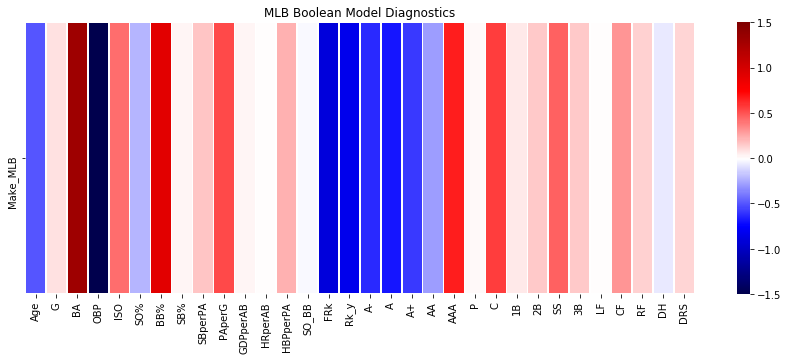

multi class model train error is: 0.21881435181820386
multi class model test error is: 0.22541966426858512
per player WAR loss is: 2.295223555487234
per player Mean Square WAR loss is: 4.5549109889493
running pitching model
(44221, 22)
fraction train classification error MLB or no: 0.2168701944821348
fraction test classification error MLB or no: 0.21549709806286274


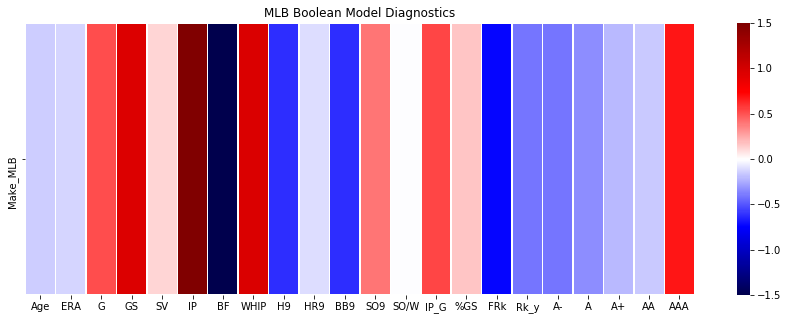

multi class model train error is: 0.24438413990652796
multi class model test error is: 0.24779561383676238
per player WAR loss is: 1.610230358611938
per player Mean Square WAR loss is: 3.411693087053703
finished


In [26]:
def set_and_run_logistic_regression(bref_test,cols_to_use,group_WARs):
    X = np.asarray(bref_test[cols_to_use].astype(float).fillna(0))
    X[X == -np.inf] = 0
    X[X == np.inf] = 0
    #add in also dummy variables, as desired

    #create also labels (i.e., y value)
    y = np.ravel(np.asarray(bref_test[['MLBBool']]))

    #and create multiclass label
    y_multi = bref_test['WARCategory']
    WARlist = list(bref_test['WARCategory'].unique())

    print(X.shape)

    #set up logistic regression
    bref_model = LogisticRegression(C=1e5, random_state=0, solver='lbfgs',max_iter=10000)
    bref_multi_model = LogisticRegression(C=1e5, random_state=0, solver='lbfgs',multi_class='multinomial',max_iter=10000)
    trans = StandardScaler()


    ### SIMPLE MODEL ###
    #train/test split
    X_,X_test,y_,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

    #fit model on training data
    bref_model.fit(trans.fit_transform(X_), y_)
    fit_model = trans
    
    #make train and test predictionss
    train_preds = bref_model.predict(trans.transform(X_))
    test_preds = bref_model.predict(trans.transform(X_test))

    ### MULTI MODEL ###
    X_m,X_testm,y_m,y_testm = train_test_split(X,y_multi,test_size=0.1,random_state=0)

    #fit model on training data
    bref_multi_model.fit(trans.fit_transform(X_m), y_m)
    fit_multi_model = trans

    bref_train_preds_multi = bref_multi_model.predict(trans.transform(X_m))
    bref_test_preds_multi = bref_multi_model.predict(trans.transform(X_testm))
    #print('yay?')

    print("fraction train classification error MLB or no: "+str((bref_model.predict(trans.transform(X_)) != y_).mean()))
    #print("train loss is: "+str(bref_model.score(X_,y_)))

    print("fraction test classification error MLB or no: "+str((bref_model.predict(trans.transform(X_test)) != y_test).mean()))
    #print("test loss is: "+str(bref_model.score(X_test,y_test)))

    #print(cols_to_use)
    #print(np.round(np.ravel(bref_model.coef_),decimals=2))

    fig, ax = plt.subplots(figsize=(15,5))         # Sample figsize in inches
    ylabs = ['Make_MLB']#WARlist#
    ax.set_title('MLB Boolean Model Diagnostics')
    sns.heatmap(np.round(bref_model.coef_,decimals=2), linewidth=0.5,ax=ax,
                     xticklabels=cols_to_use,yticklabels=ylabs,vmin=-1.5, vmax=1.5,center=0,cmap='seismic')
    plt.show()
    #print(np.round(multi_model.coef_,decimals=2))

    print("multi class model train error is: "+str((bref_multi_model.predict(trans.transform(X_m)) != y_m).mean()))
    #print("train loss is: "+str(bref_multi_model.score(X_m,y_m)))

    print("multi class model test error is: "+str((bref_multi_model.predict(trans.transform(X_testm)) != y_testm).mean()))
    #print("test loss is: "+str(bref_multi_model.score(X_testm,y_testm)))

    bref_test['probno'] = list(np.ravel(bref_model.predict_proba(trans.transform(X))[:,0]))
    bref_test['probyes'] = list(np.ravel(bref_model.predict_proba(trans.transform(X))[:,1]))
    bref_test['predstomatch'] = bref_multi_model.predict(trans.transform(X))
    for w in range(len(WARlist)):
        bref_test[bref_multi_model.classes_[w]] = list(np.ravel(bref_multi_model.predict_proba(trans.transform(X))[:,w]))

    probability_matrix = np.asarray(bref_test[bref_multi_model.classes_])
    WAR_weights = np.asarray([group_WARs['finalWAR'][group_WARs['WARCategory']==w].values[0] for w in bref_multi_model.classes_])
    WAR_weights[-1] = 0 #will want to replace na's eventually
    weighted_WAR_results = probability_matrix@WAR_weights
    bref_test['expectedWAR'] = list(weighted_WAR_results)
    print('per player WAR loss is: '+str(abs(bref_test['expectedWAR']-bref_test['finalWAR']).mean()))
    squaredcol = (bref_test['expectedWAR']-bref_test['finalWAR'])**2
    print('per player Mean Square WAR loss is: '+str((squaredcol.mean())**.5))
    
    return bref_test,bref_multi_model,bref_model,fit_model,fit_multi_model


cols_to_use = ['Age','G', 'BA', 'OBP', 'ISO', 'SO%', 'BB%','SB%','SBperPA', 'PAperG', 'GDPperAB', 'HRperAB', 'HBPperPA','SO_BB',
               'FRk', 'Rk_y', 'A-', 'A', 'A+', 'AA', 'AAA', 'P', 'C', '1B', '2B', 'SS', '3B', 'LF','CF', 'RF', 'DH','DRS']
print('running hitting model')
bref_test,bref_multi_model,bref_model,bref_model_scalar,bref_multi_scalar = set_and_run_logistic_regression(bref_test,cols_to_use,group_WARs)
#print(bref_model_scalar)
#print(bref_multi_scalar)
print('running pitching model')
cols_to_use_pitching = ['Age','ERA', 'G', 'GS', 'SV', 'IP', 'BF', 'WHIP', 'H9', 'HR9', 'BB9',
       'SO9', 'SO/W', 'IP_G','%GS', 'FRk', 'Rk_y', 'A-', 'A', 'A+', 'AA', 'AAA']
bref_test_pitching,bref_multi_model_pitching,bref_model_pitching,bref_model_scalar_pitching,bref_multi_scalar_pitching = set_and_run_logistic_regression(bref_test_pitching,cols_to_use_pitching,group_WARs_pitching)
#print(a)
print('finished')

## Visualizing Logistic Regression Results

We can see how the modeled performed on historical players. If you have a good grasp of baseball, this gives intuition of what the model is/isn't doing well at predicting. I'll also list the "top prospects in baseball history according the model." I've scaled the dots on the scatter plots to make them larger for the better players (who we care about more)

C:\Users\llavi\Anaconda4\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


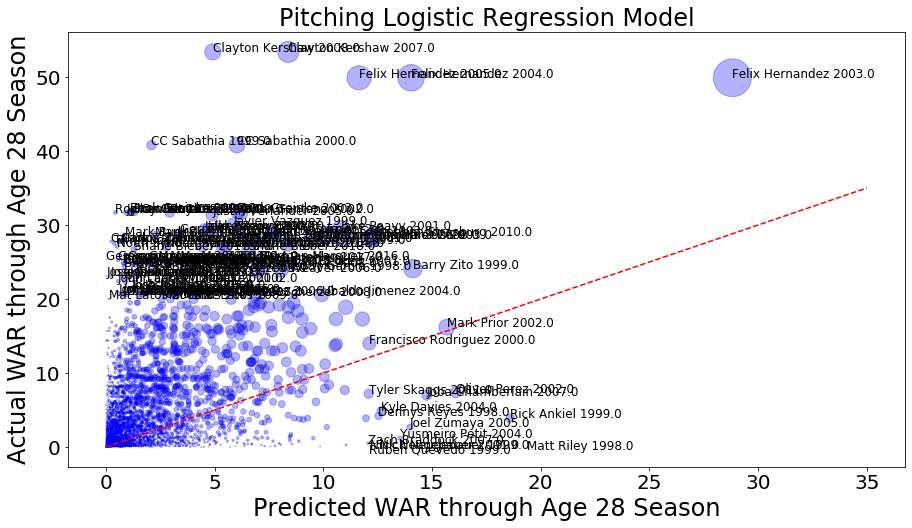

In [27]:
#pitching multi-model results diagnostic plot
plt.figure(figsize=(15,8))
plt.scatter(bref_test_pitching['expectedWAR'],bref_test_pitching['finalWAR'],
            s=bref_test_pitching['finalWAR']*bref_test_pitching['expectedWAR'],color='b',alpha=0.3)

for x,y,l1,l2 in zip(bref_test_pitching['expectedWAR'],bref_test_pitching['finalWAR'],bref_test_pitching['Name'],bref_test_pitching['season']):
    label = l1+" "+str(l2)
    if x>12 or y>20:
        #print(label)
        plt.annotate(label,
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='left',
                    size=12) # horizontal alignment can be left, right or cent
plt.plot([0, 35], [0, 35], 'k-', color = 'r',linestyle='dashed')
#plt.ylim([0,40])
plt.title('Pitching Logistic Regression Model',size=24)
plt.xlabel('Predicted WAR through Age 28 Season',size=24)
plt.ylabel('Actual WAR through Age 28 Season',size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

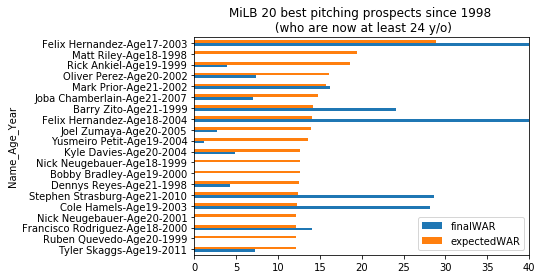

In [28]:
bref_test_pitching['Name_Age_Year'] = bref_test_pitching['Name']+"-Age"+bref_test_pitching['Age'].astype(str)+"-"+bref_test_pitching['season'].astype(int).astype(str)
bref_test_pitching_forplotting = bref_test_pitching.sort_values('expectedWAR',ascending=False)
#print(bref_test)
players_to_plot = 20
bref_short_pitching_forplotting = bref_test_pitching_forplotting.iloc[:players_to_plot,:] 
#print(bref_test.columns)
historical_vals_to_plot_short_pitching = bref_short_pitching_forplotting[['Name_Age_Year','finalWAR','expectedWAR']].set_index('Name_Age_Year')
historical_vals_to_plot_short_pitching = historical_vals_to_plot_short_pitching.sort_values('expectedWAR')

axes = plt.axes()
axes.set_xlim([0, 40])
axes.set_title('MiLB '+ str(players_to_plot)+ ' best pitching prospects since 1998 \n (who are now at least 24 y/o)')
#axes.set_ylabel('saidi_medonly')
#axes.set_xlabel('Ownership Type')
historical_vals_to_plot_short_pitching.plot(kind='barh',ax=axes)

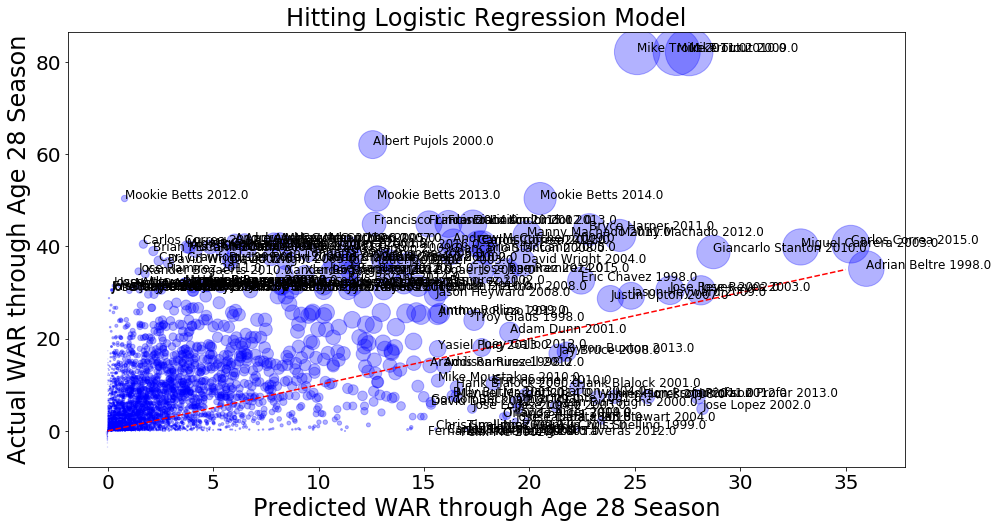

In [29]:
#diagnostic plot
plt.figure(figsize=(15,8))
plt.scatter(bref_test['expectedWAR'],bref_test['finalWAR'],
            s=bref_test['finalWAR']*bref_test['expectedWAR'],color='b',alpha=0.3)

for x,y,l1,l2 in zip(bref_test['expectedWAR'],bref_test['finalWAR'],bref_test['Name'],bref_test['season']):
    label = l1+" "+str(l2)
    if x>15 or y>30:
        #print(label)
        plt.annotate(label,
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='left',
                    size=12) # horizontal alignment can be left, right or cent
plt.plot([0, 35], [0, 35], 'k-', color = 'r',linestyle='dashed')
#plt.ylim([0,40])
plt.title('Hitting Logistic Regression Model',size=24)
plt.xlabel('Predicted WAR through Age 28 Season',size=24)
plt.ylabel('Actual WAR through Age 28 Season',size=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

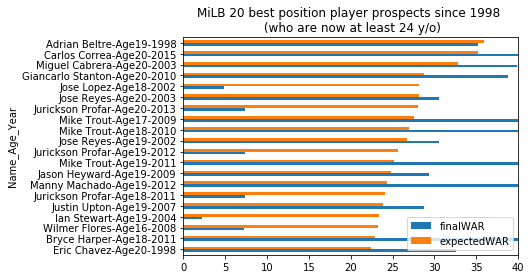

In [30]:
bref_test['Name_Age_Year'] = bref_test['Name']+"-Age"+bref_test['Age'].astype(str)+"-"+bref_test['season'].astype(int).astype(str)
bref_test_forplotting = bref_test.sort_values('expectedWAR',ascending=False)
#print(bref_test)
players_to_plot = 20
bref_short_forplotting = bref_test_forplotting.iloc[:players_to_plot,:] 
#print(bref_test.columns)
historical_vals_to_plot_short = bref_short_forplotting[['Name_Age_Year','finalWAR','expectedWAR']].set_index('Name_Age_Year')
historical_vals_to_plot_short = historical_vals_to_plot_short.sort_values('expectedWAR')

axes = plt.axes()
axes.set_xlim([0, 40])
axes.set_title('MiLB '+str(players_to_plot)+' best position player prospects since 1998 \n (who are now at least 24 y/o)')
#axes.set_ylabel('saidi_medonly')
#axes.set_xlabel('Ownership Type')
historical_vals_to_plot_short.plot(kind='barh',ax=axes)

## Logistic Regression forecasts of current minor leaguers

Now we can use our trained model to make predictions about current minor leaguers**! Presenting the best prospects in baseball!

** I haven't filtered out players who both accrued a lot of minor league playtime in 2019 and also played enough in MLB in 2019 that they are no longer considered prospects entering 2020. Baseball Reference uses different IDs for a player's minor league and major league careers and my Fangraphs data doesn't record service time so this isn't as trivial as I'd hoped. 

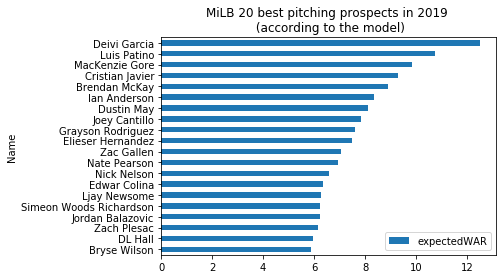

In [31]:
#rerun model on 2019 prospects
### PITCHING ###
def run_future_year(bref_year_frame,year,model,fit_scalar,cols_to_use,WARlist,group_WARs,playertype='pitching',plot=True,drop_non_rookie=False):
    if drop_non_rookie and playertype=='pitching':
        bref_year_frame['playtime'].fillna(0.)
        bref_year_frame = bref_year_frame[bref_year_frame['playtime']<50.].copy()
    elif drop_non_rookie:
        bref_year_frame['playtime'].fillna(0.)
        bref_year_frame = bref_year_frame[bref_year_frame['playtime']<130.].copy()
        
    X = np.asarray(bref_year_frame[cols_to_use].astype(float).fillna(0))
    #print(X.shape)
    trans = fit_scalar
    #bref_year_frame['probno'] = list(np.ravel(bref_model_pitching.predict_proba(trans.transform(X_2019_pitching))[:,0]))
    #bref_year_frame['probyes'] = list(np.ravel(bref_model_pitching.predict_proba(trans.transform(X_2019_pitching))[:,1]))
    #bref_year_frame['predstomatch'] = bref_multi_model_pitching.predict(trans.transform(X_2019_pitching))

    for w in range(len(WARlist)):
        bref_year_frame[model.classes_[w]] = list(np.ravel(model.predict_proba(trans.transform(X))[:,w]))

    probability_matrix = np.asarray(bref_year_frame[model.classes_])
    WAR_weights = np.asarray([group_WARs['finalWAR'][group_WARs['WARCategory']==w].values[0] for w in model.classes_])
    WAR_weights[-1] = 0 #will want to replace na's eventually
    weighted_WAR_results = probability_matrix@WAR_weights
    bref_year_frame['expectedWAR'] = list(weighted_WAR_results)
    
    if plot:
        numcut = 20
        vals_to_plot_pitching = bref_year_frame.sort_values('expectedWAR',ascending=False).iloc[:numcut,:]#.to_csv('hey.csv')
        vals_to_plot_short_pitching = vals_to_plot_pitching[['Name','expectedWAR']].set_index('Name')
        vals_to_plot_short_pitching = vals_to_plot_short_pitching.sort_values('expectedWAR')

        axes = plt.axes()
        axes.set_title('MiLB '+str(numcut)+' best '+playertype+' prospects in '+str(year)+' \n (according to the model)')
        vals_to_plot_short_pitching.plot(kind='barh',ax=axes)
    
    return bref_year_frame

WARlist = list(bref_test_pitching['WARCategory'].unique())
bref_2019_pitching_wlogistic = run_future_year(bref_2019_pitching,2019,bref_multi_model_pitching,
                                               bref_multi_scalar_pitching,cols_to_use_pitching,WARlist,group_WARs_pitching)

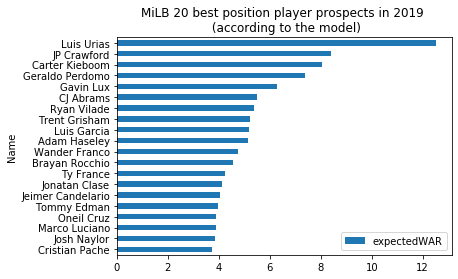

In [32]:
WARlist = list(bref_test['WARCategory'].unique())
bref_2019_hitting_wlogistic = run_future_year(bref_2019,2019,bref_multi_model,bref_multi_scalar,cols_to_use,WARlist,group_WARs,playertype='position player')

In [33]:
#load other years for later use but don't plot them
WARlist = list(bref_test['WARCategory'].unique())
bref_2018_hitting_wlogistic = run_future_year(bref_2018,2018,bref_multi_model,bref_multi_scalar,cols_to_use,WARlist,group_WARs,playertype='position player',plot=False)
bref_2017_hitting_wlogistic = run_future_year(bref_2017,2017,bref_multi_model,bref_multi_scalar,cols_to_use,WARlist,group_WARs,playertype='position player',plot=False)

WARlist = list(bref_test_pitching['WARCategory'].unique())
bref_2018_pitching_wlogistic = run_future_year(bref_2018_pitching,2018,bref_multi_model_pitching,bref_multi_scalar_pitching,cols_to_use_pitching,WARlist,group_WARs_pitching,plot=False)
bref_2017_pitching_wlogistic = run_future_year(bref_2017_pitching,2017,bref_multi_model_pitching,bref_multi_scalar_pitching,cols_to_use_pitching,WARlist,group_WARs_pitching,plot=False)

#bref_2018_pitching_wlogistic.iloc[:5,:]
#bref_test

## Neural Network Approach Intro

The logistic regression approach was fun, but it created categories that it then mapped to WAR outcomes. We could just try to predict outcome directly by transforming the features in a way that's predictive of future WAR. Let's use a neural network to do that.

I mostly use linear with ReLU layers because our intuition about the data is there are a lot of players who never make MLB, but once you do make MLB, then increasing talent has increasing returns. ReLU functions have this kind of "hinged" shape. Honestly, the linear layers I kind of just see as linearly transforming the data, which I probably could have done with PCA or kernel methods otherwise.

The next two cells prepare neural network data and then load in the model. 

In [34]:
#print(bref_test)

def prepare_NN_data(bref_test,cols_to_use,sample_size,test_size):
    
    X = np.asarray(bref_test[cols_to_use].astype(float).fillna(0))
    X[X == -np.inf] = 0
    X[X == np.inf] = 0
    
    random.seed(0)
    mysample = random.sample(range(sample_size), test_size)
    mytrain = [i for i in range(X.shape[0]) if i not in mysample]
    X_norm = (X / X.max(axis=0))
    y_np = np.asarray(bref_test['finalWAR'].astype(float).fillna(0))[:,None]
    Xtest = X_norm[mysample,:]
    Xtrain = X_norm[mytrain,:]
    ytest = y_np[mysample,:]
    ytrain = y_np[mytrain,:]
    return Xtrain,Xtest,ytrain,ytest

Xtrain_hitting,Xtest_hitting,ytrain_hitting,ytest_hitting = prepare_NN_data(bref_test,cols_to_use,45500,9000)

Xtrain_pitching,Xtest_pitching,ytrain_pitching,ytest_pitching = prepare_NN_data(bref_test_pitching,cols_to_use_pitching,44000,9000)


In [35]:
def run_baseball_NN(Xtrain,Xtest,ytrain,ytest,epochs,batch_size,learning_rate):
    orig_test_loss = 5000
    torch_tensor_y_reals = torch.from_numpy(ytrain).float()
    torch_tensor_X = torch.from_numpy(Xtrain).float()
    x_and_y = torch.from_numpy(np.hstack((Xtrain,ytrain))).float()
    x_and_y_test = torch.from_numpy(np.hstack((Xtest,ytest))).float()

    # N is batch size; D_in is input dimension;
    # H is hidden dimension; D_out is output dimension.

    N,D_in,H,D_out = batch_size,torch_tensor_X.shape[1],31,torch_tensor_y_reals.shape[1]
    #x = torch_tensor_X
    #y = torch_tensor_y_reals
    # 

    train_dataloader = torch.utils.data.DataLoader(x_and_y, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(x_and_y_test,batch_size=batch_size)

    # Use the nn package to define model and loss function
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.Sigmoid(),
        torch.nn.Linear(H, D_out),
        torch.nn.ReLU(),
    )
    loss_fn = torch.nn.MSELoss(reduction='sum') #MSE loss chosen for same reason as given previously
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)
    
    for t in range(epochs):
        # Forward pass
        total_train_loss = 0
        for data in train_dataloader:
            if data.shape[0]==batch_size:
                x = data[:,:(data.shape[1]-1)]
                y = data[:,(data.shape[1]-1):]
                y_pred = nn_model(x)

                # Compute loss
                loss = loss_fn(y_pred, y)
                #print loss every 100 epochs
                if t % 50 == 1:
                    total_train_loss+=loss.item()
                    #print(t, loss.item())
 
                optimizer.zero_grad()
                #back pass
                loss.backward()
                #update
                optimizer.step()
            
        if t % 50 == 1:
            print('after '+str(t)+'/'+str(epochs)+' epochs, training RMSE loss in WAR per player is: '+str(round((total_train_loss/Xtrain.shape[0])**.5,4)))
            total_test_loss = 0
            for testdata in test_dataloader:
                x_test = testdata[:,:(testdata.shape[1]-1)]
                y_test = testdata[:,(testdata.shape[1]-1):]
                test_y_pred = nn_model(x_test)
                test_loss = loss_fn(test_y_pred, y_test)
                total_test_loss+=test_loss.item()
            print('test RMSE loss in WAR per player is: '+str(round((total_test_loss/Xtest.shape[0])**.5,4)))
            if orig_test_loss < (total_test_loss/Xtest.shape[0])**.5:
                return nn_model #return if we have stopped decreasing test loss
            else:
                orig_test_loss = (total_test_loss/Xtest.shape[0])**.5 #update
    return nn_model
            
#nn_model_hitting = run_baseball_NN(Xtrain_hitting,Xtest_hitting,ytrain_hitting,ytest_hitting,100,500,.0004)
#nn_model_pitching = run_baseball_NN(Xtrain_pitching,Xtest_pitching,ytrain_pitching,ytest_pitching,100,500,.0002)

## Run Neural Network

**BE CAREFUL HERE**. These cells each take about an hour to run (for me on a laptop with 2 cores) to the point of convergence (set to be when test error stops decreasing), about 3500-5000 epochs. You are welcome to do this, but know that future cells allow you to just load in results from a model I already ran. They will update you on progress, so you get a sense of how long things would take.

Also, I mucked around quite a bit with the learning rate, but it's still a bit fiddly. The input value (.0003-.0005) should work, but be very careful if you change it (the model can easily get stuck predicting 0 WAR for all players).

I am going to code the model to run only 102 epochs (just to give you a sense), and then overwrite the results with the pre-loaded model later. You are free to change the "epochs_to_run" parameter and run more epochs.

In [36]:
#this cell runs and saves the neural networks defined above, and will take awhile if you've a lot of epochs
###PITCHING###
#about 3500-5000 epochs seem to be needed for minimizing test loss

epochs_to_run = 5000 #but by default I'm inputting only 102
nn_model_pitching = run_baseball_NN(Xtrain_pitching,Xtest_pitching,ytrain_pitching,ytest_pitching,epochs_to_run,500,.0004)
print(nn_model_pitching)

after 1/5000 epochs, training RMSE loss in WAR per player is: 2.0633
test RMSE loss in WAR per player is: 2.42
after 51/5000 epochs, training RMSE loss in WAR per player is: 2.0113
test RMSE loss in WAR per player is: 2.3565
after 101/5000 epochs, training RMSE loss in WAR per player is: 1.9957
test RMSE loss in WAR per player is: 2.3363
after 151/5000 epochs, training RMSE loss in WAR per player is: 1.9826
test RMSE loss in WAR per player is: 2.3186
after 201/5000 epochs, training RMSE loss in WAR per player is: 1.9708
test RMSE loss in WAR per player is: 2.3019
after 251/5000 epochs, training RMSE loss in WAR per player is: 1.9606
test RMSE loss in WAR per player is: 2.2872
after 301/5000 epochs, training RMSE loss in WAR per player is: 1.952
test RMSE loss in WAR per player is: 2.2747
after 351/5000 epochs, training RMSE loss in WAR per player is: 1.945
test RMSE loss in WAR per player is: 2.2643
after 401/5000 epochs, training RMSE loss in WAR per player is: 1.9392
test RMSE loss i

after 3551/5000 epochs, training RMSE loss in WAR per player is: 1.8454
test RMSE loss in WAR per player is: 2.1661
after 3601/5000 epochs, training RMSE loss in WAR per player is: 1.8447
test RMSE loss in WAR per player is: 2.1658
after 3651/5000 epochs, training RMSE loss in WAR per player is: 1.8441
test RMSE loss in WAR per player is: 2.1655
after 3701/5000 epochs, training RMSE loss in WAR per player is: 1.8435
test RMSE loss in WAR per player is: 2.1653
after 3751/5000 epochs, training RMSE loss in WAR per player is: 1.843
test RMSE loss in WAR per player is: 2.1651
after 3801/5000 epochs, training RMSE loss in WAR per player is: 1.8424
test RMSE loss in WAR per player is: 2.1647
after 3851/5000 epochs, training RMSE loss in WAR per player is: 1.8417
test RMSE loss in WAR per player is: 2.1644
after 3901/5000 epochs, training RMSE loss in WAR per player is: 1.8413
test RMSE loss in WAR per player is: 2.1641
after 3951/5000 epochs, training RMSE loss in WAR per player is: 1.8408
t

In [38]:
#this cell runs and saves the neural networks defined above, and will take awhile if you've a lot of epochs
###HITTING###
#about 3500-5000 epochs seem to be needed for minimizing test loss
epochs_to_run = 5000 #but by default I'm inputting only 102
nn_model_hitting = run_baseball_NN(Xtrain_hitting,Xtest_hitting,ytrain_hitting,ytest_hitting,epochs_to_run,500,.0004)
print(nn_model_hitting)

after 1/5000 epochs, training RMSE loss in WAR per player is: 2.882
test RMSE loss in WAR per player is: 3.2915
after 51/5000 epochs, training RMSE loss in WAR per player is: 2.8571
test RMSE loss in WAR per player is: 3.2627
after 101/5000 epochs, training RMSE loss in WAR per player is: 2.8392
test RMSE loss in WAR per player is: 3.2429
after 151/5000 epochs, training RMSE loss in WAR per player is: 2.8219
test RMSE loss in WAR per player is: 3.2222
after 201/5000 epochs, training RMSE loss in WAR per player is: 2.8038
test RMSE loss in WAR per player is: 3.1998
after 251/5000 epochs, training RMSE loss in WAR per player is: 2.7865
test RMSE loss in WAR per player is: 3.1779
after 301/5000 epochs, training RMSE loss in WAR per player is: 2.7704
test RMSE loss in WAR per player is: 3.1576
after 351/5000 epochs, training RMSE loss in WAR per player is: 2.7555
test RMSE loss in WAR per player is: 3.1395
after 401/5000 epochs, training RMSE loss in WAR per player is: 2.7419
test RMSE los

## Run Neural Net on Future Years

If you've trained a neural network, you can use it to predict how minor leaguers in 2017-2019 will perform in their MLB careers. Again, **ONLY** run this if you've trained the Neural Network. And, I'll overwrite it in the next cell block with a previously run version.

In [39]:
##only run this cell if you've trained the neural net. 
def runNNfutureyear(bref_df,cols_to_use,nn_model,batch_size):
    
    X = np.asarray(bref_df[cols_to_use].astype(float).fillna(0))
    X[X == -np.inf] = 0
    X[X == np.inf] = 0
    X_normed = X / X.max(axis=0)
    X_normed = np.nan_to_num(X_normed)

    test_dataloader = torch.utils.data.DataLoader(torch.from_numpy(X_normed).float(), batch_size=batch_size)
    
    results_list = []
    for data in test_dataloader:
            if data.shape[0]==batch_size:
                x = data
                y_pred = nn_model(x)
                #print(y_pred)
                results_list+=list(np.ravel(y_pred.detach().numpy()))
    if len(results_list)!=len(bref_2019.index):
        for v in range(len(bref_df.index)-len(results_list)):
            results_list.append(0.)
    #print(len(results_list))
    #print(len(bref_df.index))
    bref_df['nnWAR'] = results_list
    return bref_df

#run hitting with updated nn
bref_2019_hitting_wnn = runNNfutureyear(bref_2019_hitting_wlogistic,cols_to_use,nn_model_hitting,500)
bref_2018_hitting_wnn = runNNfutureyear(bref_2018_hitting_wlogistic,cols_to_use,nn_model_hitting,500)
bref_2017_hitting_wnn = runNNfutureyear(bref_2017_hitting_wlogistic,cols_to_use,nn_model_hitting,500)

#run pitching with updated nn
bref_2017_pitching_wnn = runNNfutureyear(bref_2017_pitching_wlogistic,cols_to_use_pitching,nn_model_pitching,500)
bref_2018_pitching_wnn = runNNfutureyear(bref_2018_pitching_wlogistic,cols_to_use_pitching,nn_model_pitching,500)
bref_2019_pitching_wnn = runNNfutureyear(bref_2019_pitching_wlogistic,cols_to_use_pitching,nn_model_pitching,500)

bref_2017_hitting_wnn.iloc[:5,:] #printing just helps make sure things worked

C:\Users\llavi\Anaconda4\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


,Unnamed: 0,Rk_x,Name,Age,Tm,Lev,G,PA,AB,R,...,playtime,12-20WAR,2-6WAR,20-30WAR,6-12WAR,<2WAR,>30WAR,NoMLB,expectedWAR,nnWAR
0,10025.0,6.0,Ozzie Albies,20,GWI,AAA,97.0,448.0,411.0,67.0,...,244.0,0.168771,0.059286,0.104509,0.205202,0.376662,0.072169,0.013400,9.735161,4.387091
1,20898.0,60.0,Rafael Devers,20,"PRT,PAW","AA,AAA",86.0,358.0,322.0,54.0,...,240.0,0.135777,0.061031,0.086027,0.158640,0.120631,0.387930,0.049964,20.373286,17.383232
2,106594.0,50.0,Matt Chapman,24,"NVL,STK","AAA,A+",51.0,212.0,182.0,30.0,...,326.0,0.069741,0.243819,0.070466,0.277111,0.319230,0.002245,0.017389,6.063091,19.715530
3,101599.0,304.0,Gleyber Torres,20,"TRE,SWB","AA,AAA",55.0,235.0,202.0,31.0,...,NaN,0.116020,0.100552,0.082436,0.197514,0.351346,0.064525,0.087607,8.200643,6.006516
4,31558.0,175.0,Yoan Moncada,22,CHR,AAA,80.0,361.0,309.0,57.0,...,231.0,0.132623,0.092351,0.041094,0.129590,0.568233,0.004436,0.031673,4.561377,6.066632


## Overwrite Neural Net Results with Previously trained model

As titled. The commented out section of code provides a skeleton for exporting results that I previously used. I'm writing this right now to overwrite what the user ran in their Neural Net by default, so if you don't want this to happen, **DO NOT** run this cell. But also know if you've only run the default number of epochs (100), your Neural Net will predict about 0 WAR for all players (it's not trained yet).

In [43]:
#you can export and save dataframes if you've trained the model
#but seriously, only uncomment this and do so if you've run the model fully

exported_frames = {'hitting2017':bref_2017_hitting_wnn,
                    'hitting2018':bref_2018_hitting_wnn,
                    'hitting2019':bref_2019_hitting_wnn,
                    'pitching2017':bref_2017_pitching_wnn,
                    'pitching2018':bref_2018_pitching_wnn,
                    'pitching2019':bref_2019_pitching_wnn
}
for frame in exported_frames.keys():
    filename = 'saved_dataframes\\'+frame+'.csv'
    exported_frames[frame].to_csv(os.path.join(os.getcwd(),filename))

#load earlier run versions of model if don't want to wait for nn to run
#2017
'''
bref_2017_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2017.csv'))
bref_2017_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2017.csv'))
#2018
bref_2018_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2018.csv'))
bref_2018_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2018.csv'))
#2019
bref_2019_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2019.csv'))
bref_2019_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2019.csv'))
'''

"\nbref_2017_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2017.csv'))\nbref_2017_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2017.csv'))\n#2018\nbref_2018_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2018.csv'))\nbref_2018_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2018.csv'))\n#2019\nbref_2019_pitching_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\pitching2019.csv'))\nbref_2019_hitting_wnn = pd.read_csv(os.path.join(os.getcwd(),'saved_dataframes\\hitting2019.csv'))\n"

## Payoff: Final Results

Now we can predict minor league player outcomes using both the Logistic Regression and Neural Network models we've trained! I'll call the results the player's predicted "ensemble" WAR, a simple average between the two models. Note that while the Neural Network achieves lower training/test error in RMS WAR per player on the historical, I'm more worried about its forward exogeneity for use with the 2017-2019 data so a simple average seems fair. 

I didn't get around to changing labels, so the Logistic Regression bars will just be titled "Expected WAR" still. Players are sorted by their ensemble predicted WAR.

Also, the final plot joins pitchers and position players and plots them jointly, since, ultimately, teams do have to compare these players.

The user is able to change the year to plot to any of the years 2017-2019, though I'll use 2019 as a default.

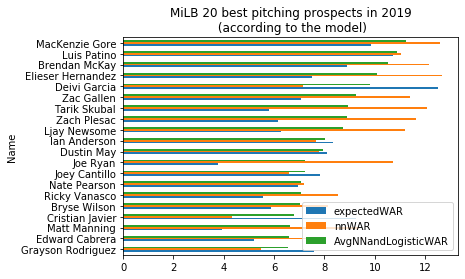

In [40]:
#plot nn predictions with other predictions
def plot_both_WAR(bref_df_year,year,numcut,playertype='position player'):
    #numcut = 20
    bref_df_year['AvgNNandLogisticWAR'] = 0.5*(bref_df_year['expectedWAR']+bref_df_year['nnWAR'])
    vals_to_plot = bref_df_year.sort_values('AvgNNandLogisticWAR',ascending=False).iloc[:numcut,:]
    vals_to_plot_short = vals_to_plot[['Name','expectedWAR','nnWAR','AvgNNandLogisticWAR']].set_index('Name')
    vals_to_plot_short = vals_to_plot_short.sort_values('AvgNNandLogisticWAR')

    axes = plt.axes()
    axes.set_title('MiLB '+str(numcut)+' best '+playertype +' prospects in '+str(year)+'\n (according to the model)')
    vals_to_plot_short.plot(kind='barh',ax=axes)
    return None

plot_both_WAR(bref_2019_pitching_wnn,2019,20,playertype='pitching')

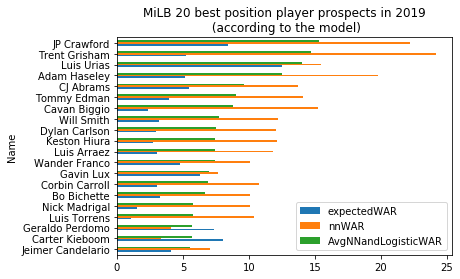

In [41]:
plot_both_WAR(bref_2019_hitting_wnn,2019,20)

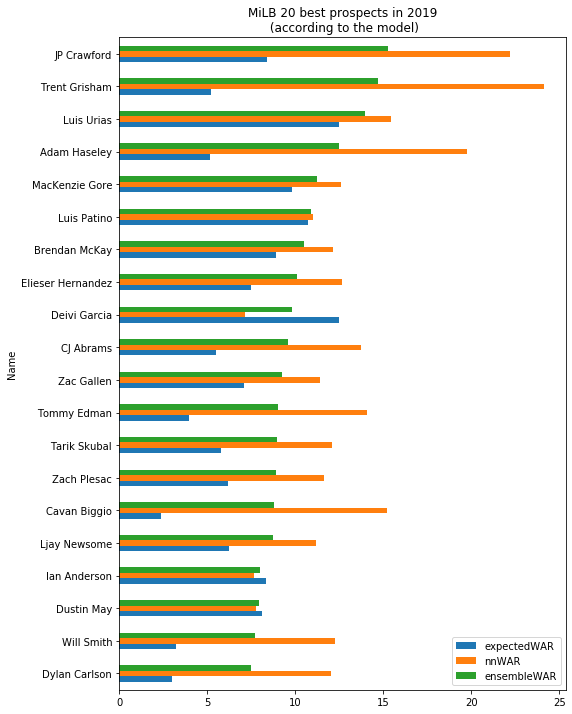

In [42]:
#join pitching and hitting data and report jointly

def join_and_plot_stats(hitting_df_year,pitching_df_year,year,numcut):
    #bref_2019_pitching_tojoin = pitching_df_year
    #pitching_df_year['Position'] = ['P']*len(pitching_df_year.index)
    #print(hit_results_loaded.columns)
    #give hitting players a position to report?
    #print(bref_2019_pitching_tojoin.columns)

    dfs_to_concat = [hitting_df_year[['Name','Age','Tm','Lev','expectedWAR','nnWAR']],
                    pitching_df_year[['Name','Age','Tm','Lev','expectedWAR','nnWAR']]]#list same columns
    
    concatenated_stats = pd.concat(dfs_to_concat, ignore_index=True) #concatenate subset dataframes
    concatenated_stats['ensembleWAR'] = 0.5*(concatenated_stats['expectedWAR']+concatenated_stats['nnWAR']) # create ensemble WAR
    
    vals_to_plot_both = concatenated_stats.sort_values('ensembleWAR',ascending=False).reset_index()#.to_csv('hey.csv')
    vals_to_plot_both_iloc = vals_to_plot_both.iloc[:numcut,:]
    vals_to_plot_short_both = vals_to_plot_both_iloc[['Name','expectedWAR','nnWAR','ensembleWAR']].set_index('Name')
    vals_to_plot_short_both = vals_to_plot_short_both.sort_values('ensembleWAR')

    fig, axes = plt.subplots(figsize=(8,12))
    #axes = plt.axes()
    axes.set_title('MiLB '+str(numcut)+' best prospects in '+str(year)+'\n (according to the model)')
    vals_to_plot_short_both.plot(kind='barh',ax=axes)
    
    return concatenated_stats

#print(bref_2019_wnn.columns)
joined_stats = join_and_plot_stats(bref_2019_hitting_wnn,bref_2019_pitching_wnn,2019,20)
#joined_stats_2019.sort_values('ensembleWAR',ascending=False)